## Introduction
This notebook tries to take in a sample dataset in notebook environment and run some tests to demo the verification of differential privacy algorithms. 

### Load the DP Verification Modules

In [1]:
import pandas as pd
import dp_verification as dp
import aggregation as agg

### Load Data

In [2]:
dv = dp.DPVerification(dataset_size=10000)
ag = agg.Aggregation(t=1, repeat_count=10000)

Loaded 10000 records


### Test Parameters

In [3]:
# Using the auto method of np.histogram to decide bin size
# Maximum of the ‘sturges’ and ‘fd’ estimators. Provides good all around performance.
numbins = 0

## Exact Counts

In [4]:
dp_exact, ks_exact, ws_exact = dv.aggtest(ag.exact_count, 'UserId', binsize = "unity", bound = False, exact = True)

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.0  Stdev fD1:  0.0  Mean fD2:  9999.0  Stdev fD2:  0.0

KS 2-sample Test Result:  Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Wasserstein Distance:  0.0 

DP Predicate Test: False 



If we do exact count repeatedly on a set D1 of 10K records and set D1 of 9,999 records (neighboring datasets), we shall get two histograms that are easily distinguishable from each other. So we can make out the extra record is in D1 vs D2. This is a trivial case of re-identification as it leads us to infer net new information about an individual record being part of D1 vs D2. 

#### Exact count fails the DP test

## Buggy Implementation of DP

In [5]:
dp_buggy, ks_buggy, ws_buggy = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False,bound = True)

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10005.00640527369  Stdev fD1:  2.872289302860187  Mean fD2:  10003.992950500719  Stdev fD2:  2.887608362720967

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1074, pvalue=1.2941082951613566e-50) 

Wasserstein Distance:  2.9655172413793096 

DP Predicate Test: False 



#### We can see that the histograms are not bounded. The test is able to uncover this implementation of DP noisy count is incorrect which is what we'd expect this test to uncover. 

## [DP Implementation as per MSR equations](https://www.yammer.com/microsoft.com/#/files/182490914816)

### COUNT Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.95480932162  Stdev fD1:  5.301563575745068  Mean fD2:  9998.998384731454  Stdev fD2:  5.3200400066447

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0784, pvalue=3.808765148627586e-27) 

Wasserstein Distance:  5.45679012345679 

DP Predicate Test: True 



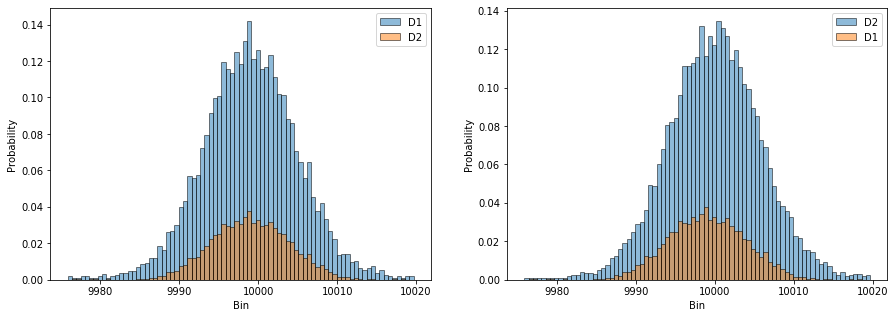

In [6]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False)

#### Noisy COUNT aggregation passes the DP Predicate test

### SUM Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.054263432346  Stdev fD1:  64.51719634087591  Mean fD2:  20009.962483381896  Stdev fD2:  63.84899576819309

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0275, pvalue=0.0010385517933069264) 

Wasserstein Distance:  4.070588235294117 

DP Predicate Test: True 



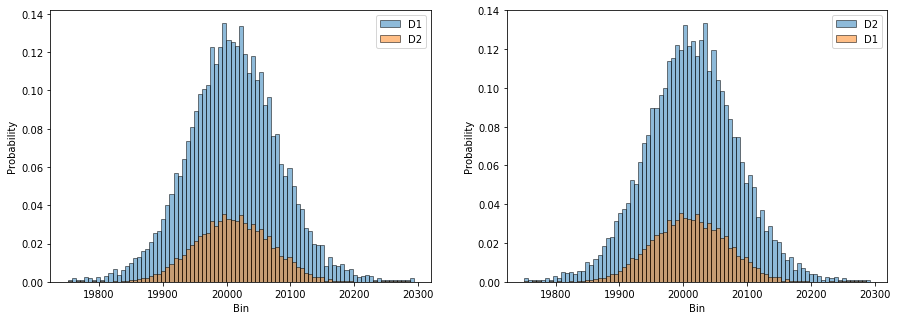

In [7]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto")

#### Noisy SUM aggregation passes the DP predicate test

### Mean Test

In [8]:
dp_mean, ks_mean, ws_mean = dv.aggtest(ag.dp_mean, 'Usage', binsize="auto", debug=False, plot=True)

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.001271207718558  Stdev fD1:  0.0064890539614701785  Mean fD2:  2.001484926140308  Stdev fD2:  0.006470230589010468

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0165, pvalue=0.13138496726749369) 

Wasserstein Distance:  5.037974683544304 

DP Predicate Test: True 



#### Noisy mean passes the DP Predicate test

### Variance Test

In [9]:
dp_var, ks_var, ws_var = dv.aggtest(ag.dp_var, 'Usage', binsize="auto", debug=False)

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.0518948383786015  Stdev fD1:  0.09250734414565505  Mean fD2:  2.051949471009194  Stdev fD2:  0.09405594151391301

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0137, pvalue=0.30504141099080584) 

Wasserstein Distance:  6.5352112676056375 

DP Predicate Test: True 



#### Noisy variance passes the DP Predicate test

### Comparing fD1 and fD2 without bounding

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.980325412766  Stdev fD1:  5.371379137621207  Mean fD2:  9999.031378543827  Stdev fD2:  5.288191355084051

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28) 

Wasserstein Distance:  4.951219512195123 

DP Predicate Test: True 



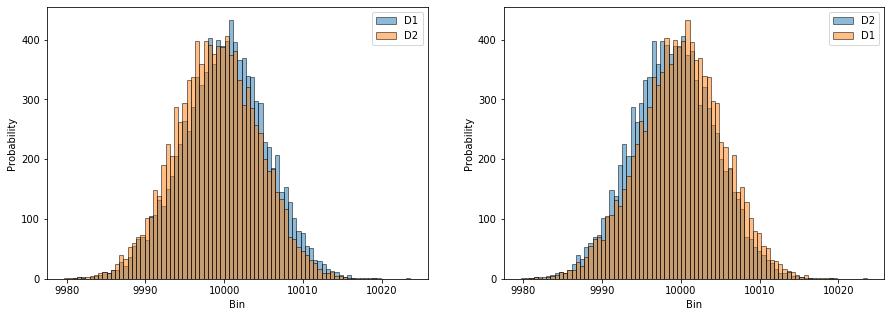

(True,
 Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28),
 4.951219512195123)

In [10]:
dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False, bound=False)

### Plotting KS Test Results by different aggregate functions

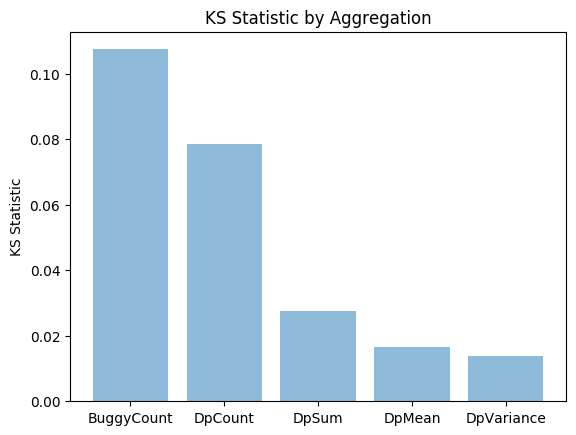

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('BuggyCount', 'DpCount', 'DpSum', 'DpMean', 'DpVariance')
y_pos = np.arange(len(objects))

ks_stat = [ks_buggy[0],
          ks_count[0],
          ks_sum[0],
          ks_mean[0],
          ks_var[0]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS Statistic')
plt.title('KS Statistic by Aggregation')

plt.show()

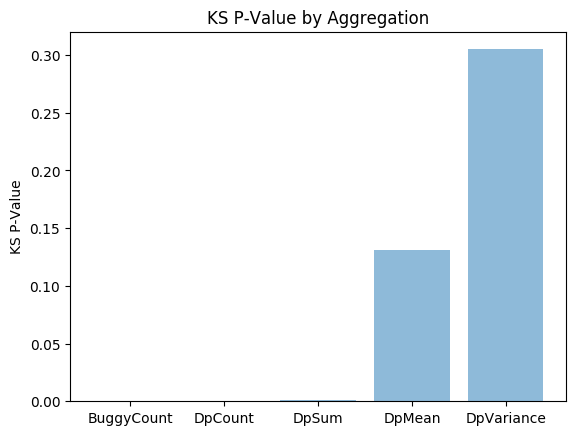

In [12]:
ks_stat = [ks_buggy[1],
          ks_count[1],
          ks_sum[1],
          ks_mean[1],
          ks_var[1]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS P-Value')
plt.title('KS P-Value by Aggregation')

plt.show()

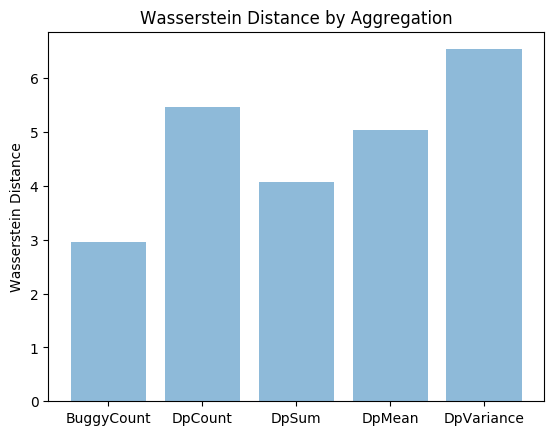

In [13]:
ws_stat = [ws_buggy,
          ws_count,
          ws_sum,
          ws_mean,
          ws_var]

plt.bar(y_pos, ws_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance by Aggregation')

plt.show()

### Time to run the DP Tests

In [14]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.003150446026  Stdev fD1:  5.329548568121991  Mean fD2:  9999.068096604222  Stdev fD2:  5.345181279124184

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0682, pvalue=1.21976233733592e-20) 

Wasserstein Distance:  4.409638554216866 

DP Predicate Test: True 

--- 0.04923868179321289 seconds ---


In [15]:
start_time = time.time()
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.521400350048  Stdev fD1:  64.33678728785993  Mean fD2:  20009.570909004782  Stdev fD2:  63.991294298451635

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0212, pvalue=0.022340230544746754) 

Wasserstein Distance:  5.788235294117644 

DP Predicate Test: True 

--- 0.05082392692565918 seconds ---


In [16]:
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.954461149271  Stdev fD1:  2.8988207643457353  Mean fD2:  10003.953225665098  Stdev fD2:  2.892072355511362

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1069, pvalue=3.793908925840325e-50) 

Wasserstein Distance:  4.689655172413794 

DP Predicate Test: False 

--- 0.035425662994384766 seconds ---


### Verifying Burdock Private Query Mechanism implementation

#### Laplace mechanism - COUNT

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.00488034203  Stdev fD1:  1.4357646546608516  Mean fD2:  9999.016541306573  Stdev fD2:  1.4052244161938787

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.3917, pvalue=0.0) 

Wasserstein Distance:  2.817610062893081 

DP Predicate Test: True 



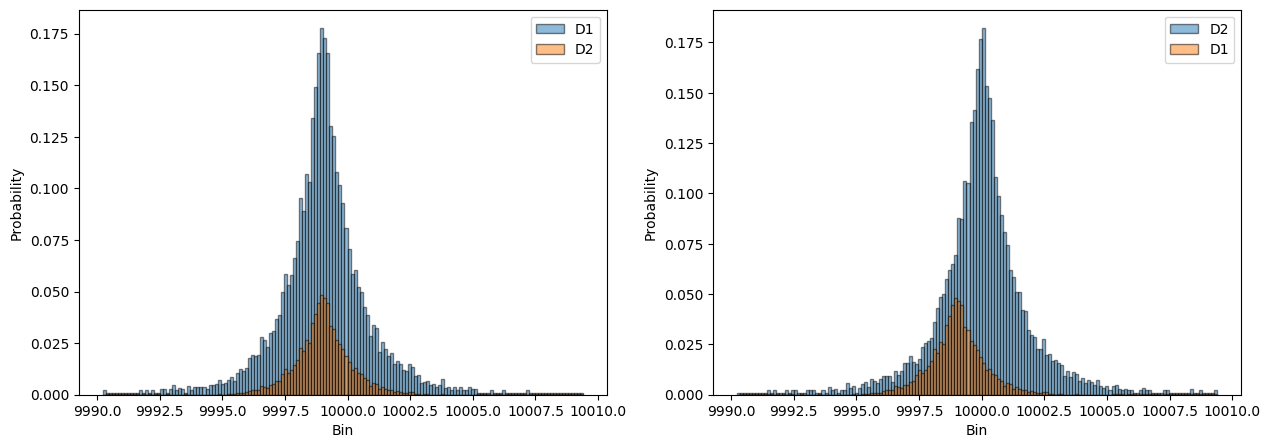

In [17]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Laplace mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.53070298395  Stdev fD1:  17.26992279096388  Mean fD2:  20010.096231039126  Stdev fD2:  16.98883382347714

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1293, pvalue=3.115527836912432e-73) 

Wasserstein Distance:  2.853658536585367 

DP Predicate Test: True 



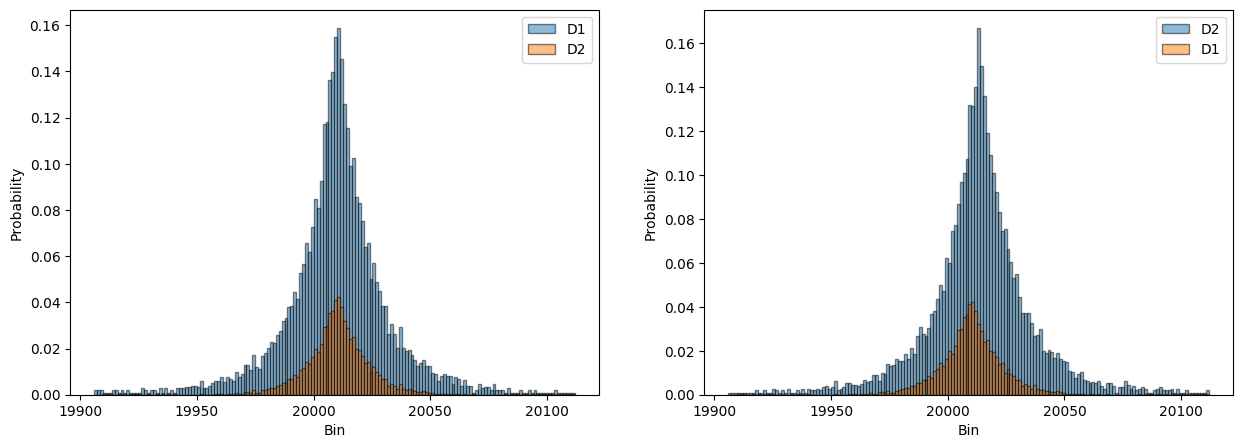

In [18]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

#### Gaussian mechanism - Count

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.915959978463  Stdev fD1:  8.656881851201776  Mean fD2:  9999.05446012761  Stdev fD2:  8.642647819920496

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0456, pvalue=1.8526953315718356e-09) 

Wasserstein Distance:  5.095890410958903 

DP Predicate Test: True 



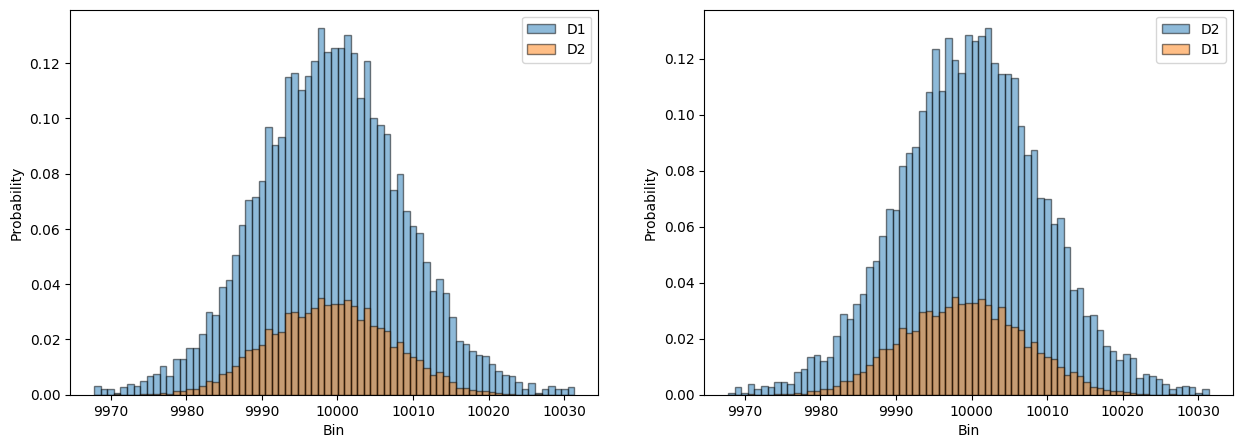

In [19]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Gaussian")
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Gaussian Mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.043964970075  Stdev fD1:  8.50556696335246  Mean fD2:  20012.217750090636  Stdev fD2:  8.70800293096627

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0442, pvalue=6.518371677470047e-09) 

Wasserstein Distance:  4.799999999999998 

DP Predicate Test: True 



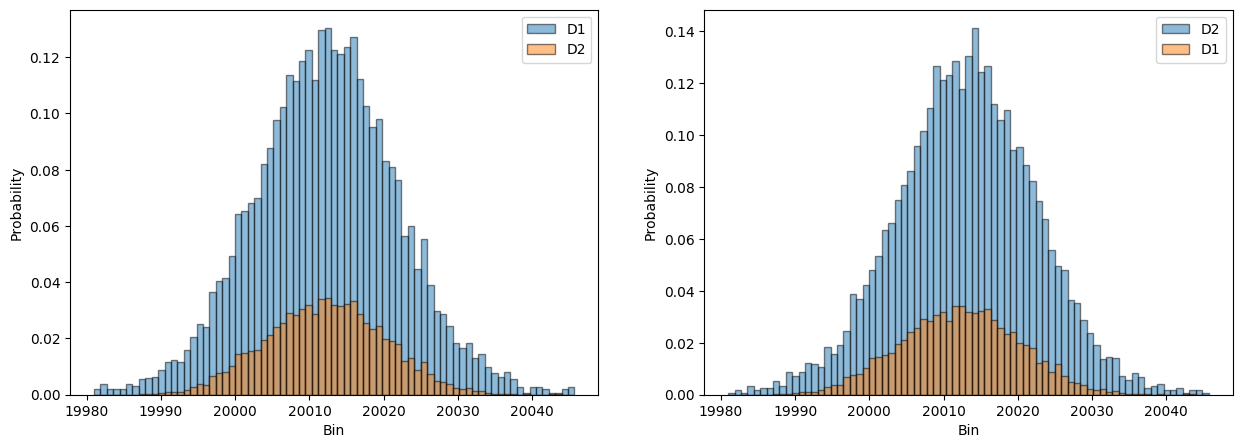

In [20]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

### Verifying Burdock Private Query implementation for a sample query

#### Note: Burdock uses Laplace noise by default right now but has support for both Laplace and Gaussian noise

### SUM DP Predicate Test

In [21]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Laplace")
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT SUM(Usage) AS TotalUsage FROM d1.d1"
d2_query = "SELECT SUM(Usage) AS TotalUsage FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999


DP Predicate Test:  True
Accuracy Test:  None
--- 13.535621881484985 seconds ---


### COUNT DP Predicate Test

Length of D1:  10000  Length of D2:  9999


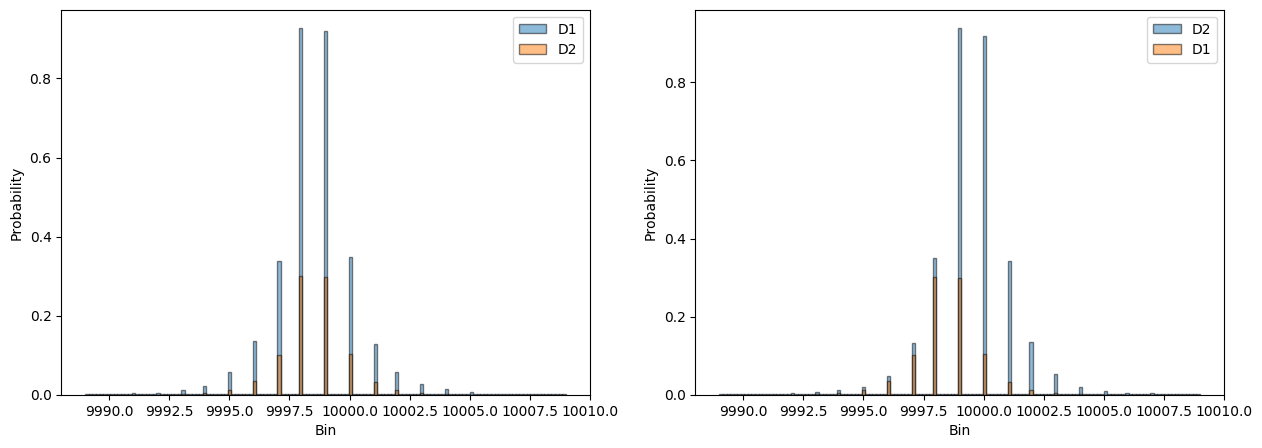

DP Predicate Test:  True
Accuracy Test:  None
--- 11.989506006240845 seconds ---


In [22]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("--- %s seconds ---" % (time.time() - start_time))

### MEAN DP Predicate Test

Length of D1:  10000  Length of D2:  9999


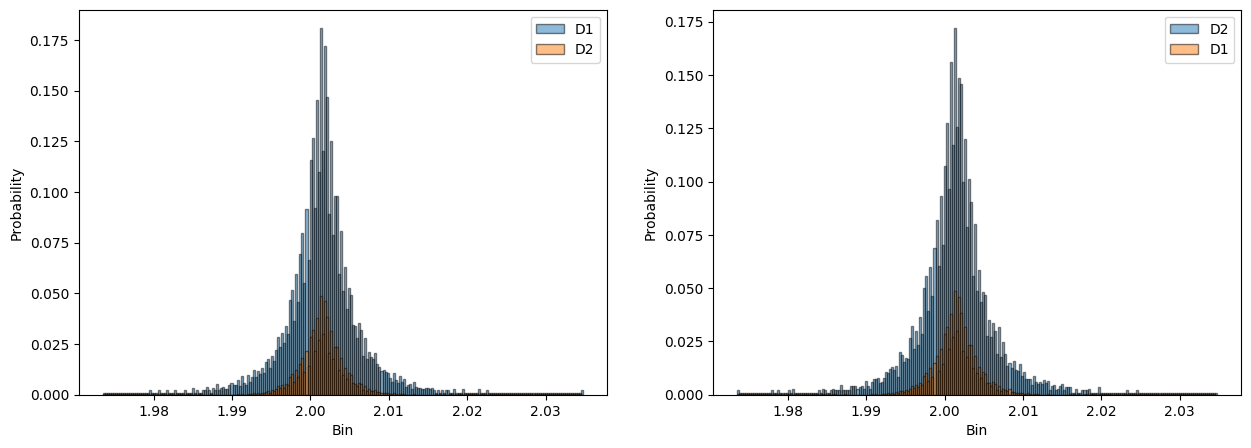

DP Predicate Test:  True
--- 18.020793199539185 seconds ---


In [23]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT AVG(Usage) AS AvgUsage FROM d1.d1"
d2_query = "SELECT AVG(Usage) AS AvgUsage FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("--- %s seconds ---" % (time.time() - start_time))

### VARIANCE DP Predicate Test

Length of D1:  10000  Length of D2:  9999


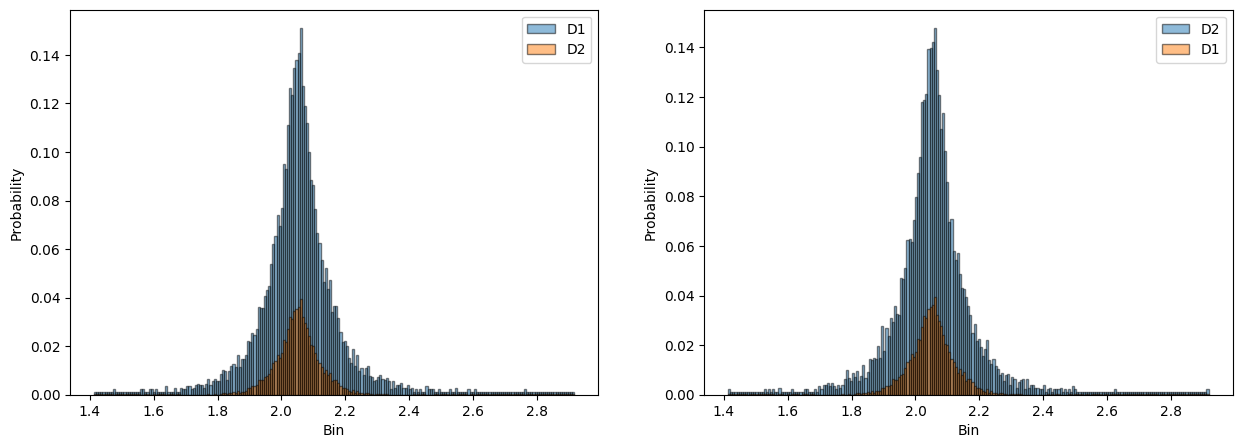

DP Predicate Test:  True
--- 26.743491649627686 seconds ---


In [24]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT VAR(Usage) AS UsageVar FROM d1.d1"
d2_query = "SELECT VAR(Usage) AS UsageVar FROM d2.d2"
dp_res, acc_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("--- %s seconds ---" % (time.time() - start_time))

### GROUP BY Test

Length of D1:  10000  Length of D2:  9999
role       R1
segment     A
Name: 0, dtype: object
Column:  usercount
DP Predicate Test Result:  True


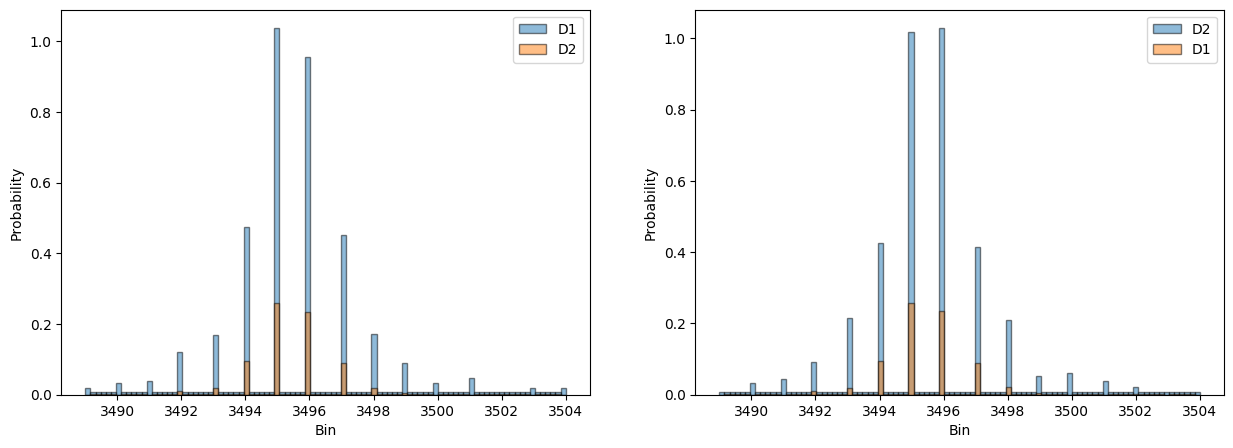

role       R1
segment     B
Name: 1, dtype: object
Column:  usercount
DP Predicate Test Result:  True


role       R1
segment     C
Name: 2, dtype: object
Column:  usercount
DP Predicate Test Result:  True


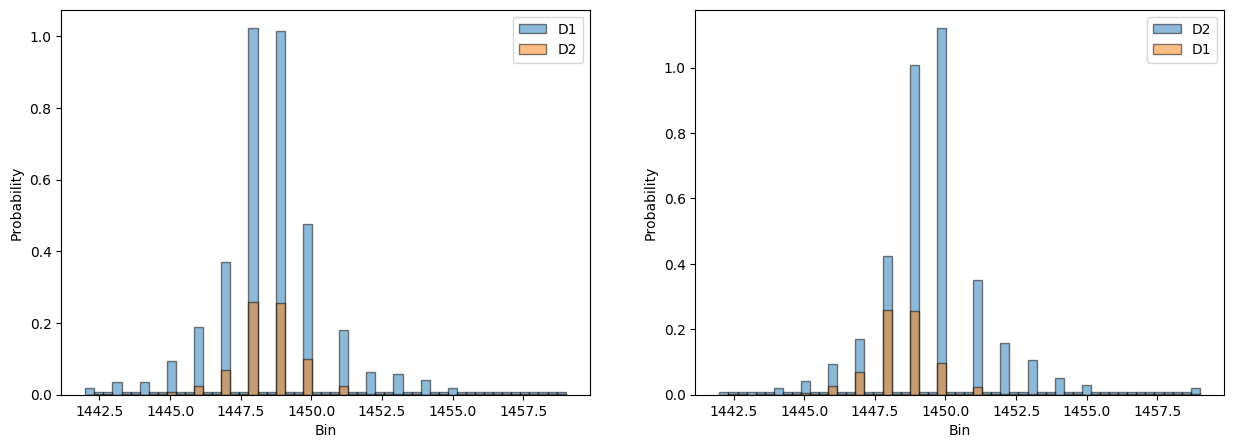

role       R2
segment     A
Name: 3, dtype: object
Column:  usercount
DP Predicate Test Result:  True


role       R2
segment     B
Name: 4, dtype: object
Column:  usercount
DP Predicate Test Result:  True


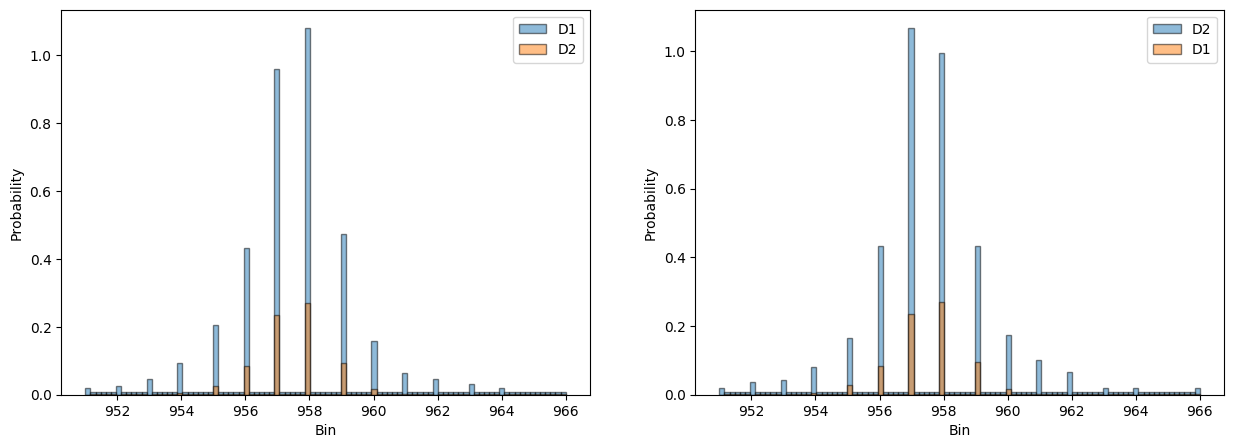

role       R2
segment     C
Name: 5, dtype: object
Column:  usercount
DP Predicate Test Result:  True


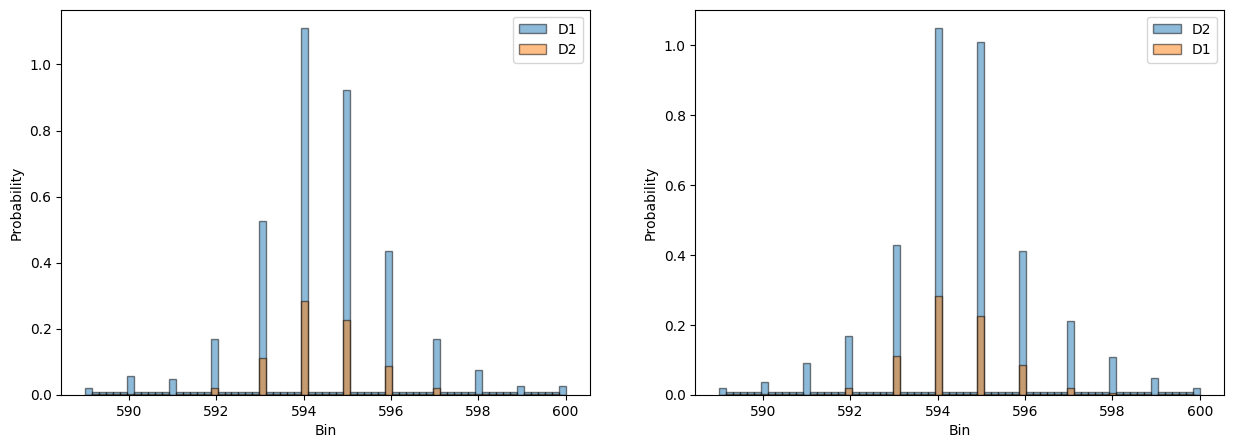

role       R1
segment     A
Name: 0, dtype: object
Column:  usage
DP Predicate Test Result:  True


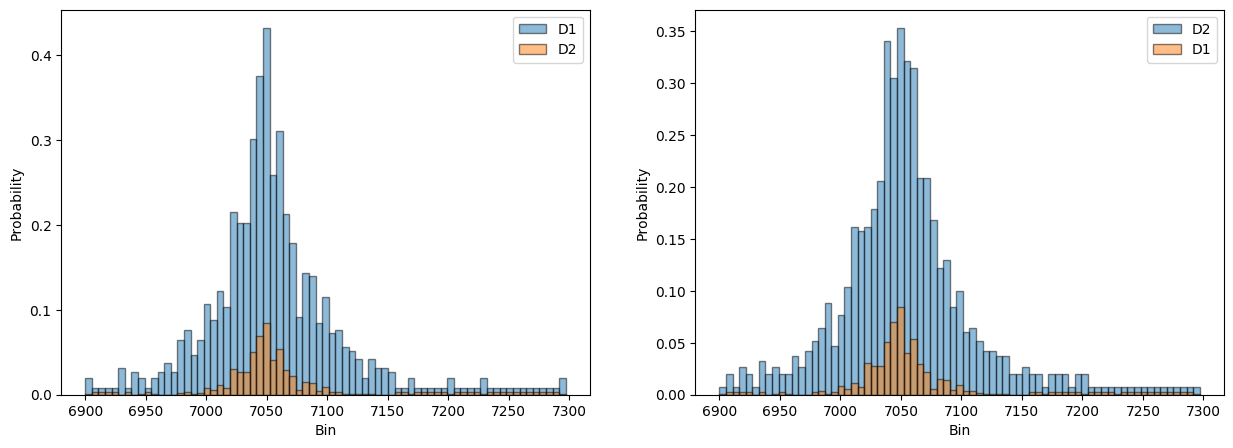

role       R1
segment     B
Name: 1, dtype: object
Column:  usage
DP Predicate Test Result:  True


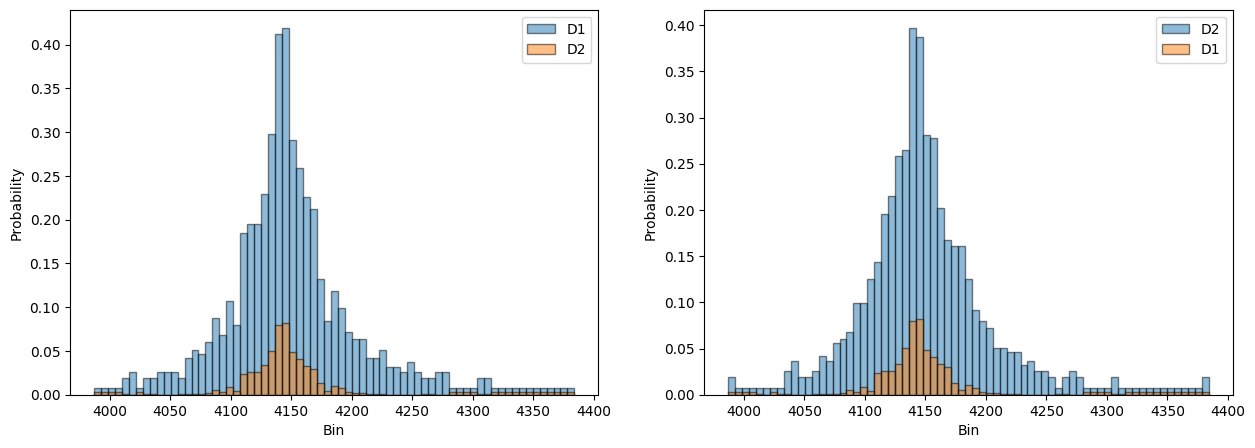

role       R1
segment     C
Name: 2, dtype: object
Column:  usage
DP Predicate Test Result:  True


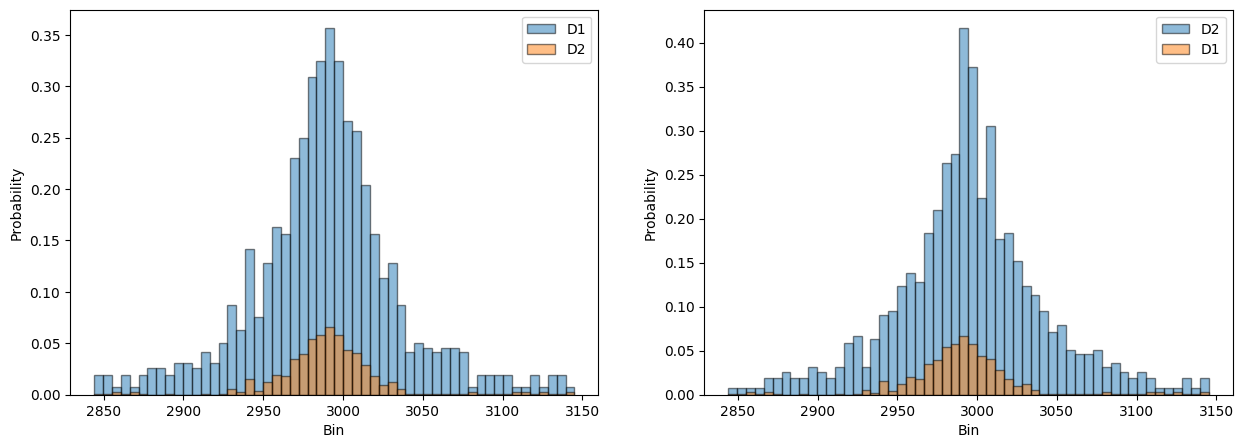

role       R2
segment     A
Name: 3, dtype: object
Column:  usage
DP Predicate Test Result:  True


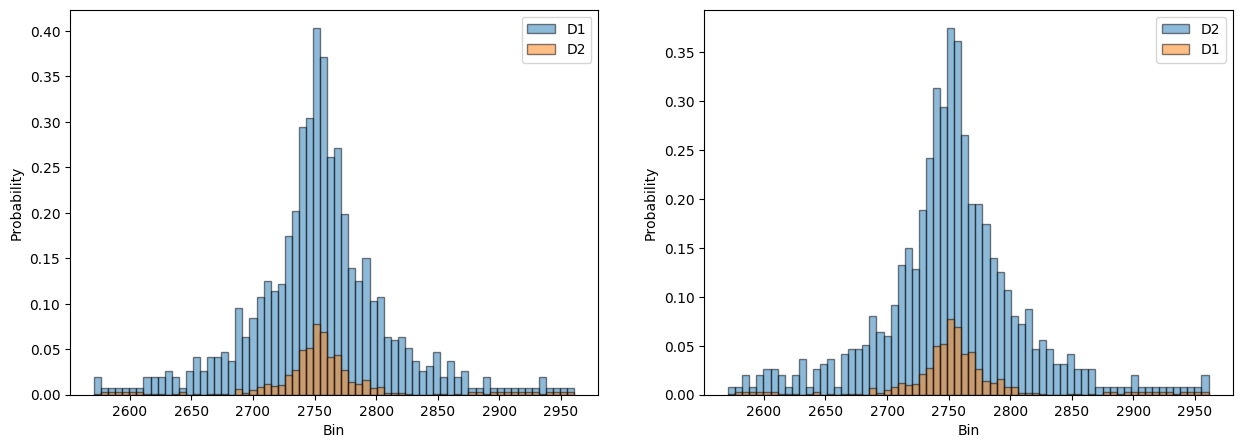

role       R2
segment     B
Name: 4, dtype: object
Column:  usage
DP Predicate Test Result:  True


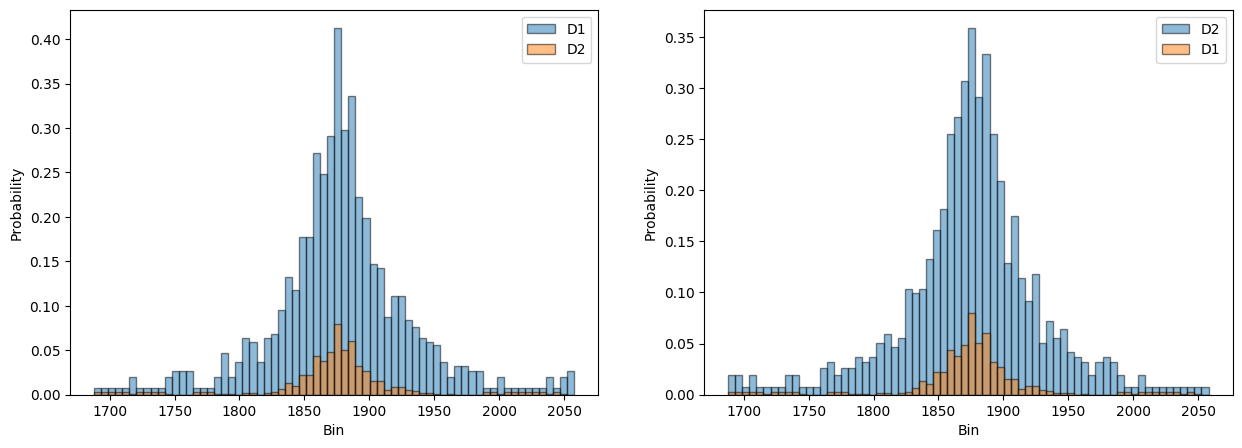

role       R2
segment     C
Name: 5, dtype: object
Column:  usage
DP Predicate Test Result:  True


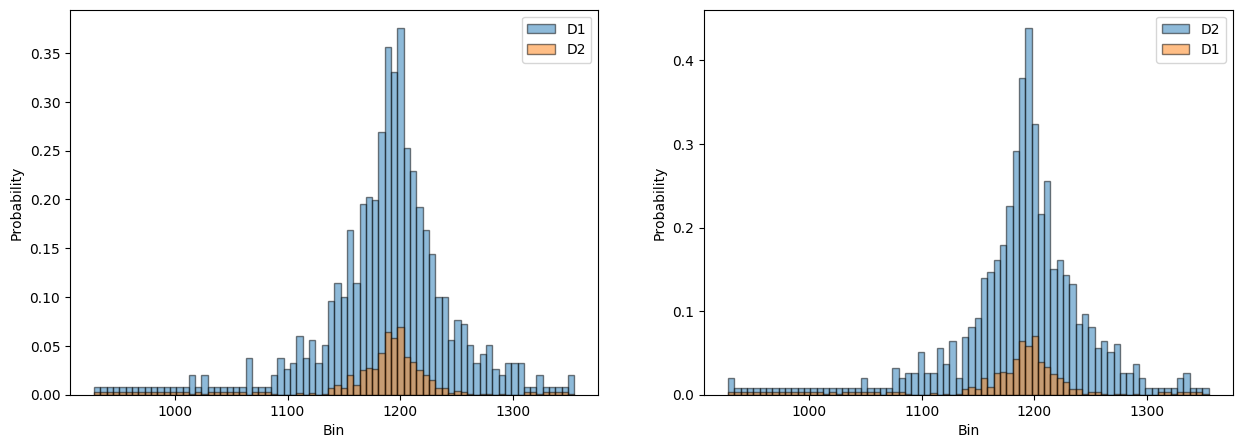

DP Predicate Test:  True
--- 13.817002773284912 seconds ---


In [25]:
start_time = time.time()
d1_query = "SELECT Role, Segment, COUNT(UserId) AS UserCount, SUM(Usage) AS Usage FROM d1.d1 GROUP BY Role, Segment"
d2_query = "SELECT Role, Segment, COUNT(UserId) AS UserCount, SUM(Usage) AS Usage FROM d2.d2 GROUP BY Role, Segment"
dp_res = dv.dp_groupby_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
__dim__    key
Name: 0, dtype: object
Column:  usercount
DP Predicate Test Result:  True


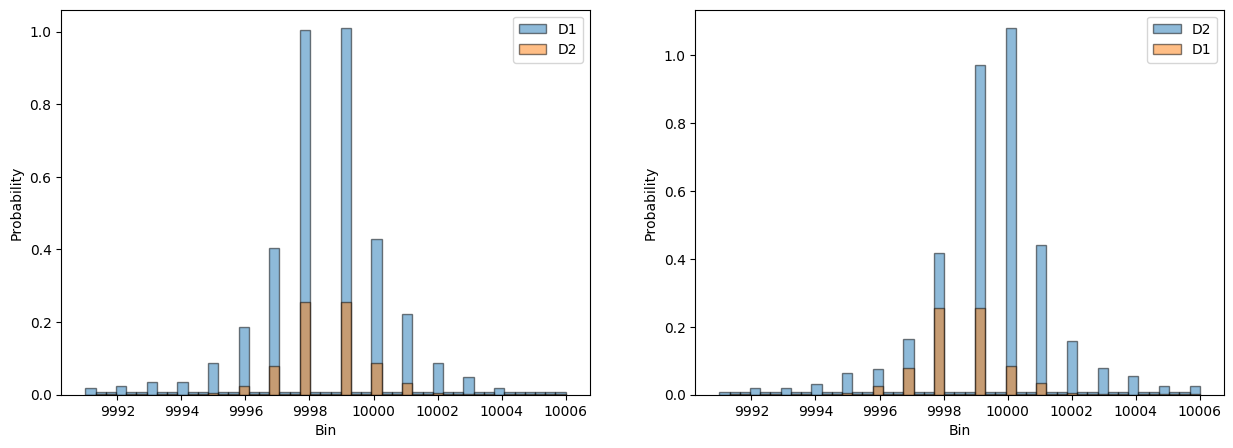

--- 1.932969331741333 seconds ---


In [26]:
start_time = time.time()
d1_query = "SELECT COUNT(UserId) AS UserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS UserCount FROM d2.d2"
dp_res = dv.dp_groupby_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("--- %s seconds ---" % (time.time() - start_time))

### Powerset Test

Test case:  [0.0, -333.33333333333337, -600.0]
Testing:  012_0
DP Predicate Test Result:  True


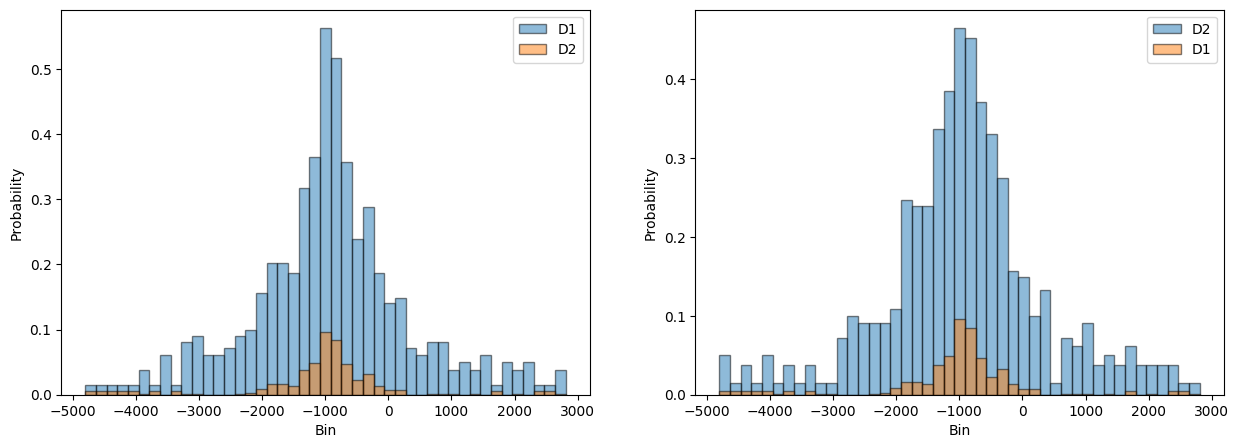

Testing:  12_1
DP Predicate Test Result:  True


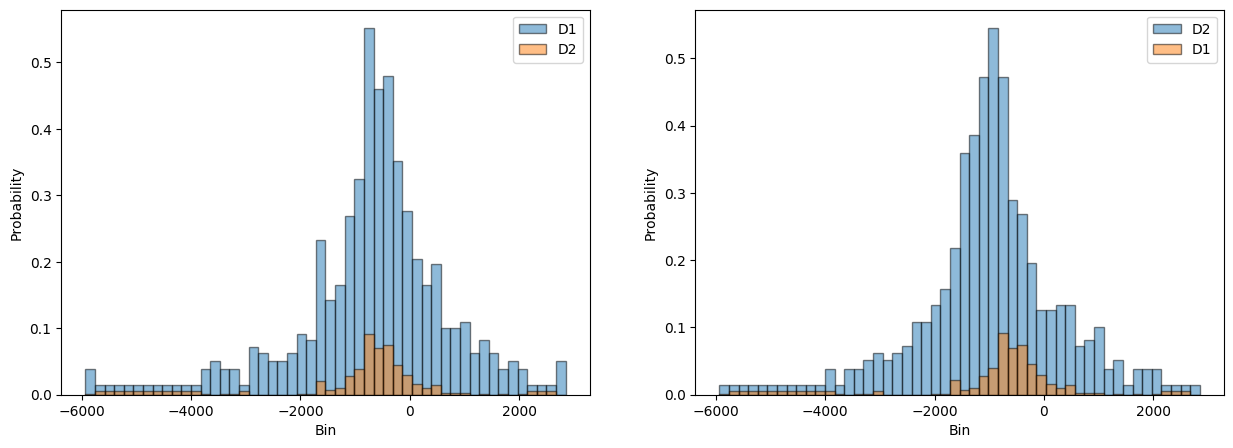

Testing:  2_2
DP Predicate Test Result:  True


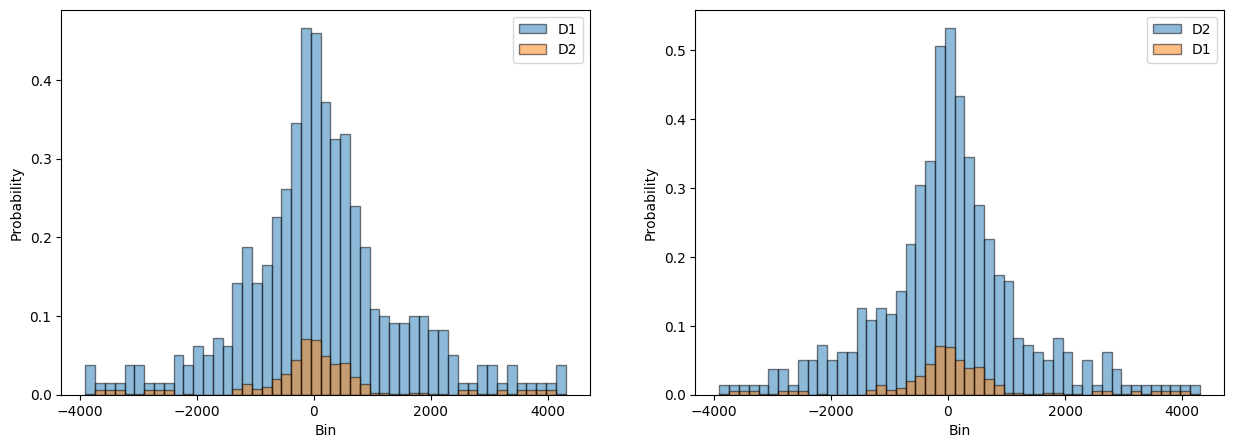

Testing:  12_2
DP Predicate Test Result:  True


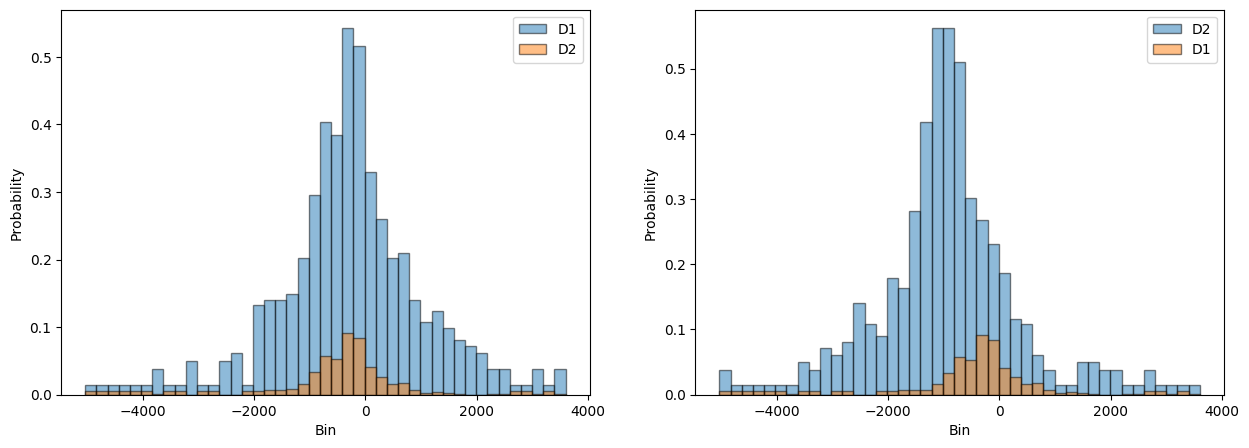

Testing:  1_1
DP Predicate Test Result:  True


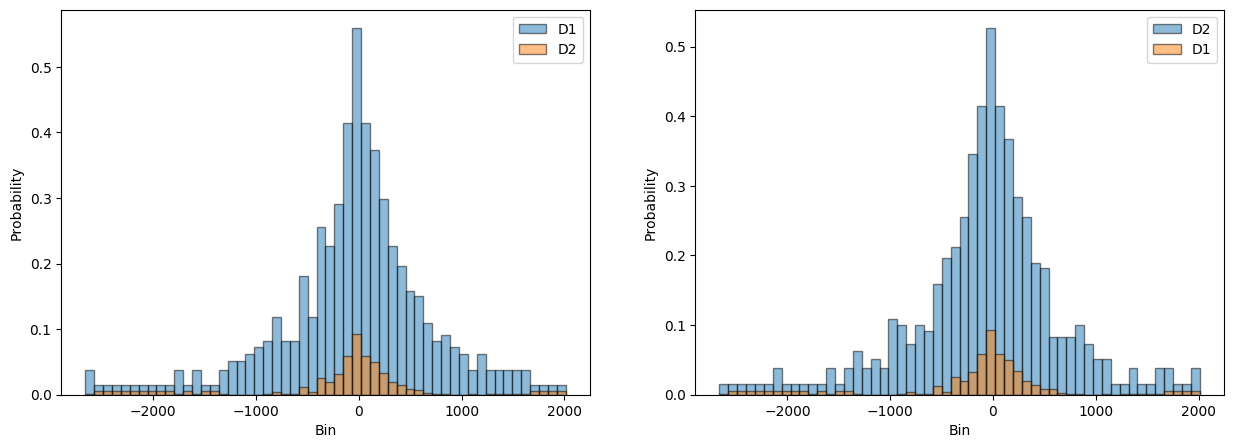

Testing:  012_1
DP Predicate Test Result:  True


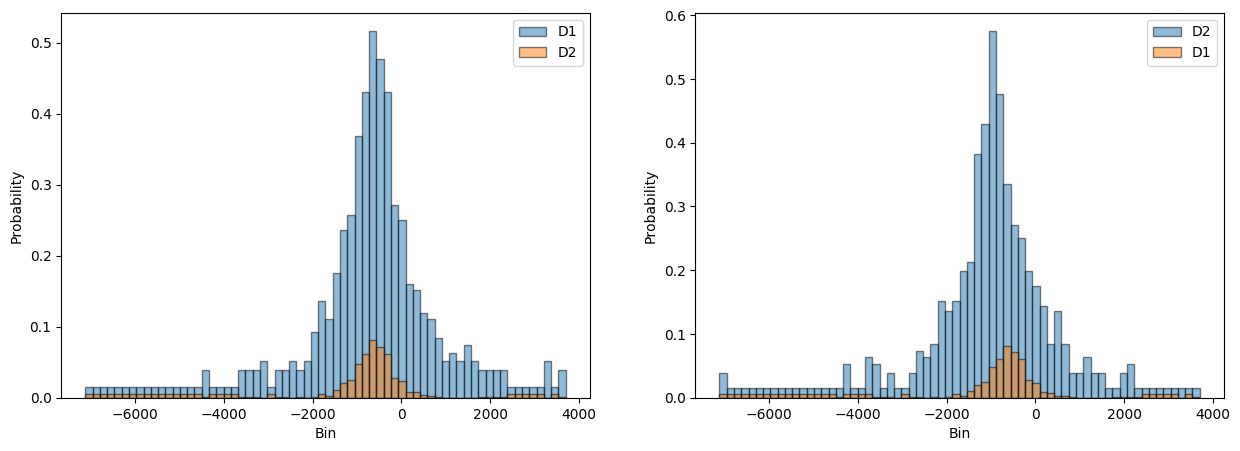

Testing:  02_0
DP Predicate Test Result:  True


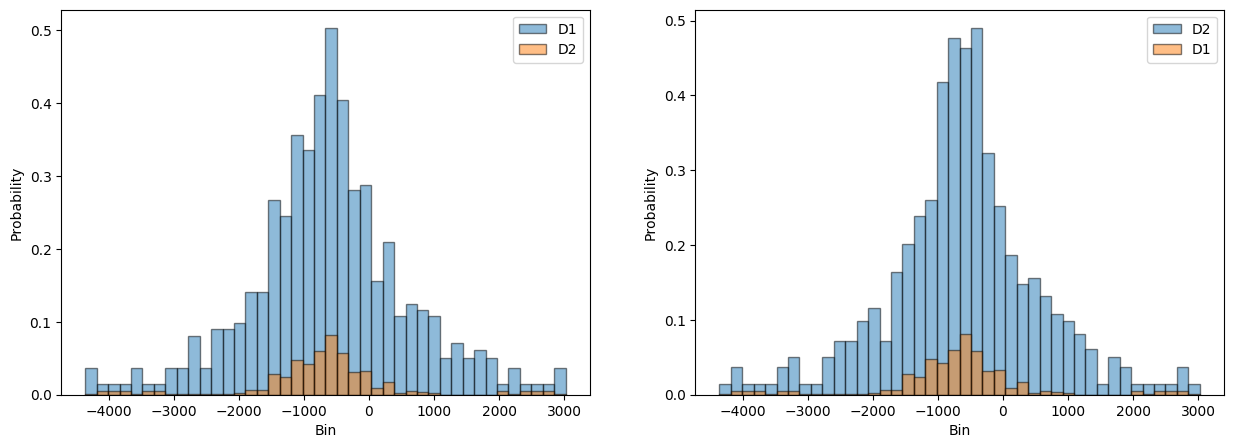

Testing:  02_2
DP Predicate Test Result:  True


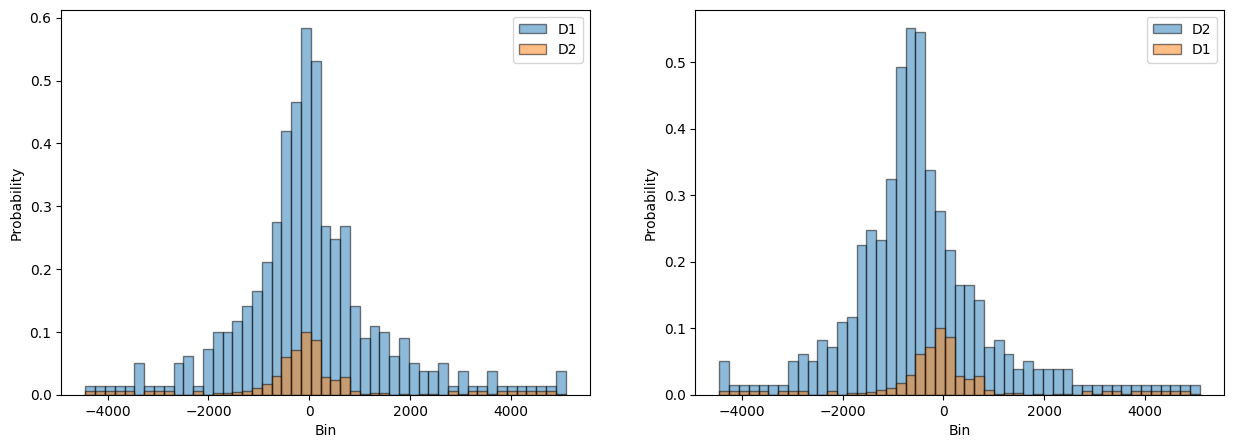

Testing:  0_0


/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


DP Predicate Test Result:  True


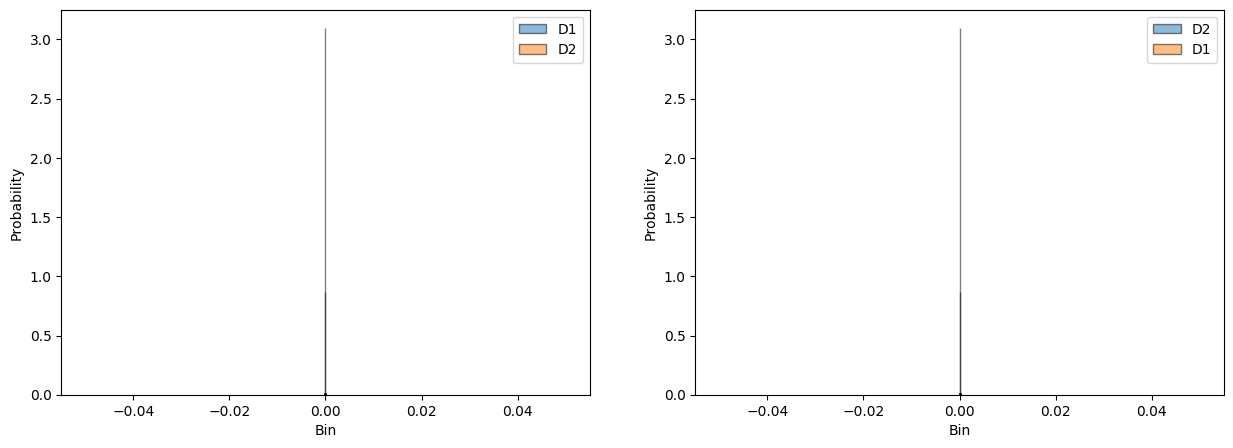

Testing:  012_2
DP Predicate Test Result:  True


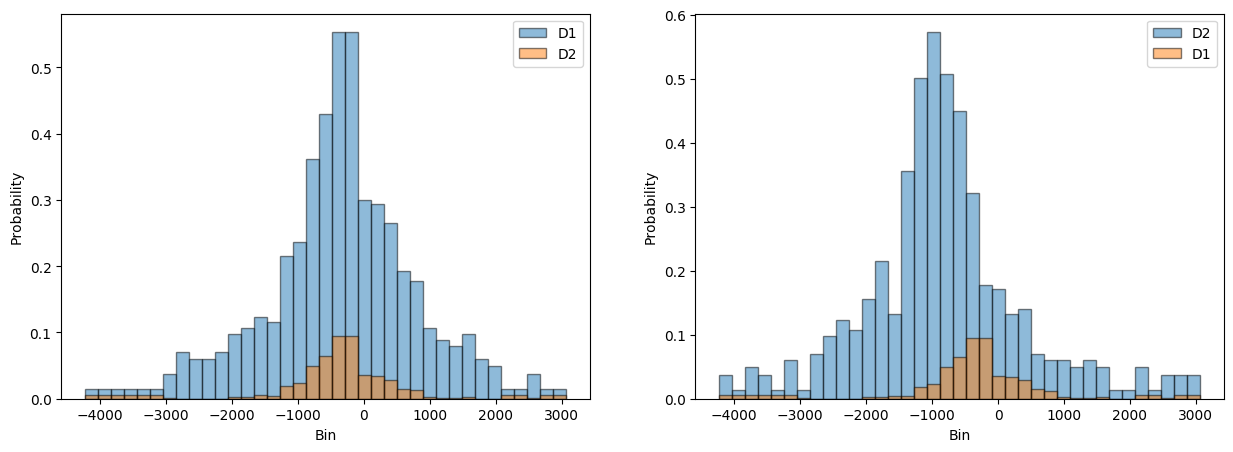

Testing:  01_0
DP Predicate Test Result:  True


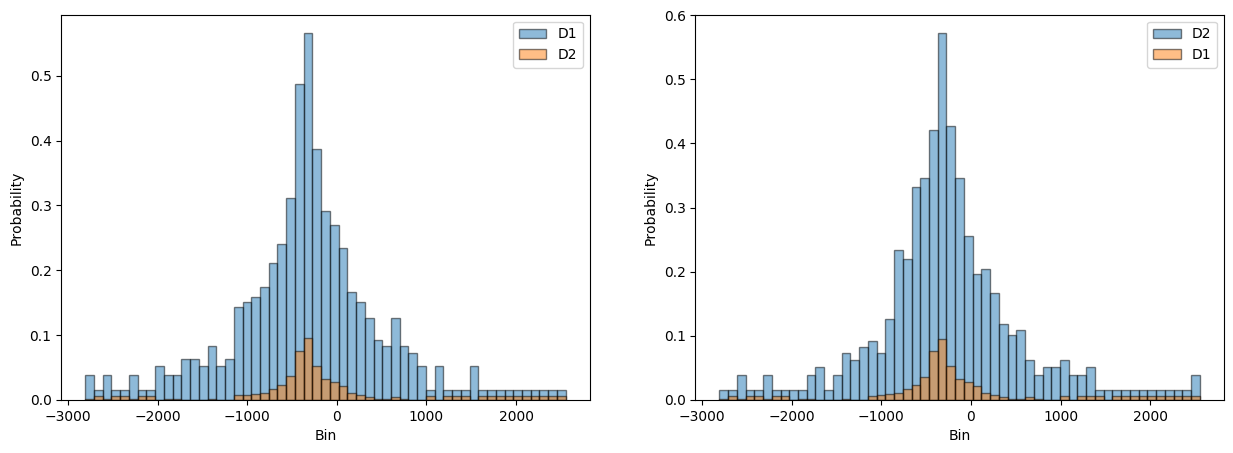

Testing:  01_1
DP Predicate Test Result:  True


Test case:  [-500.0, 333.33333333333326, -200.0]
Testing:  012_0
DP Predicate Test Result:  True


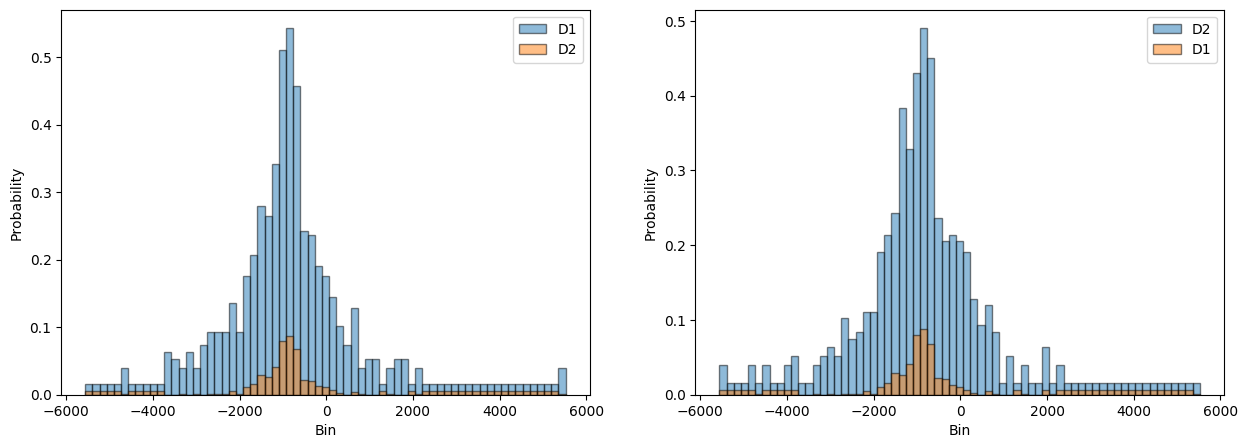

Testing:  12_1
DP Predicate Test Result:  True


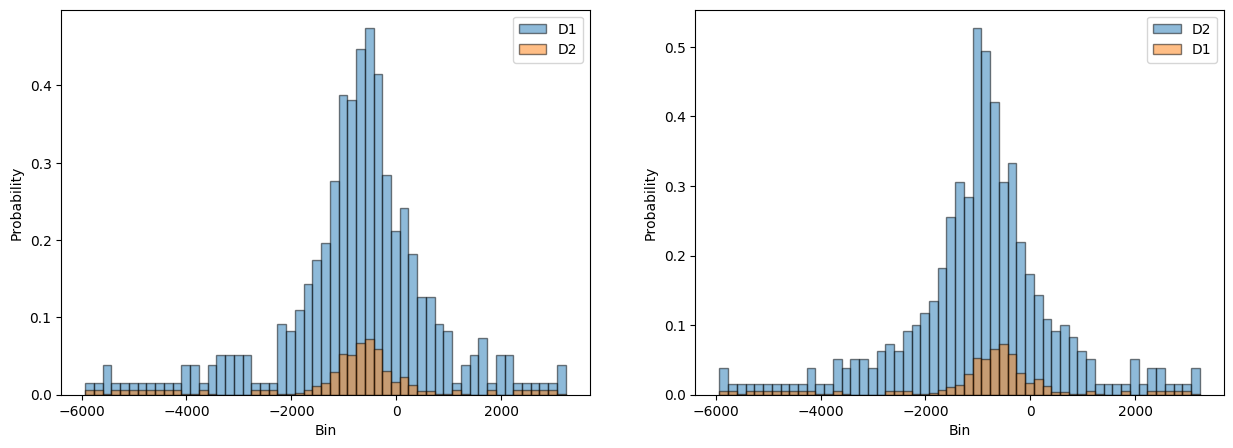

Testing:  2_2
DP Predicate Test Result:  True


Testing:  12_2
DP Predicate Test Result:  True


Testing:  1_1
DP Predicate Test Result:  True


Testing:  012_1
DP Predicate Test Result:  True


Testing:  02_0
DP Predicate Test Result:  True


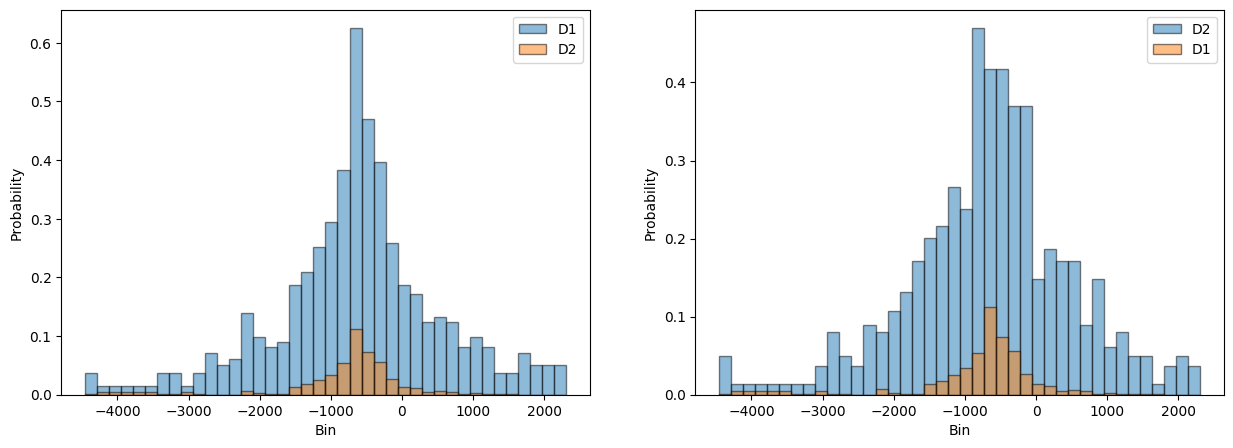

Testing:  02_2
DP Predicate Test Result:  True


Testing:  0_0


/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


DP Predicate Test Result:  True


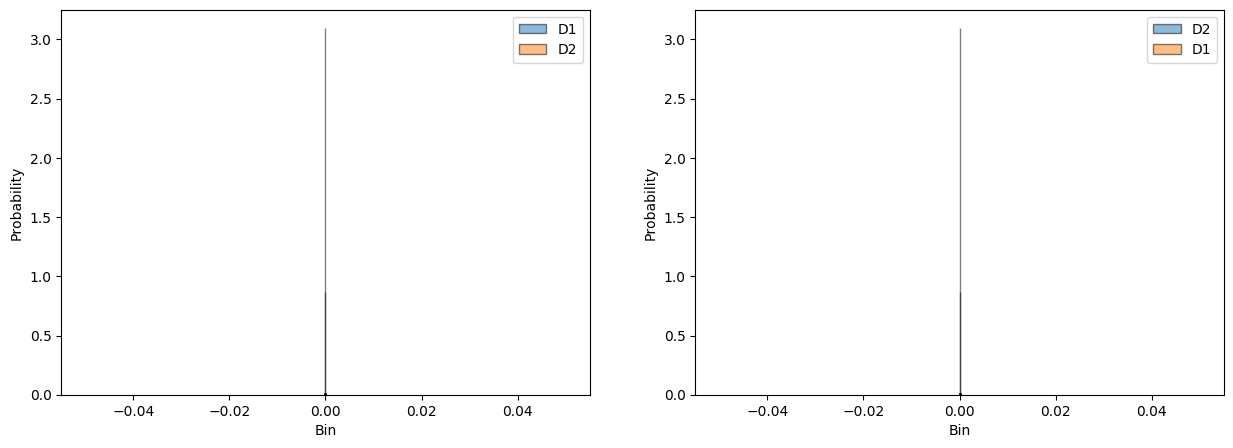

Testing:  012_2
DP Predicate Test Result:  True


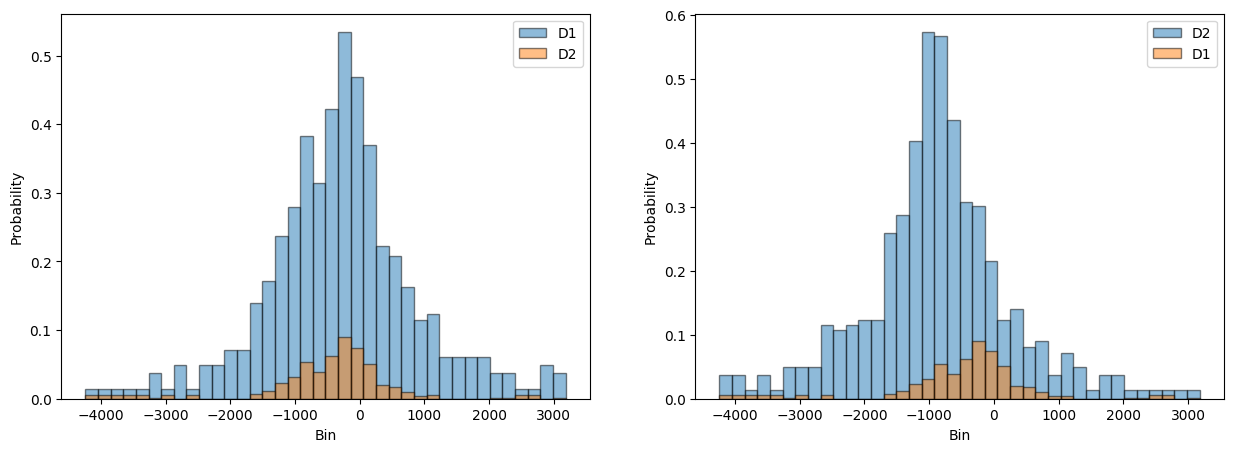

Testing:  01_0
DP Predicate Test Result:  True


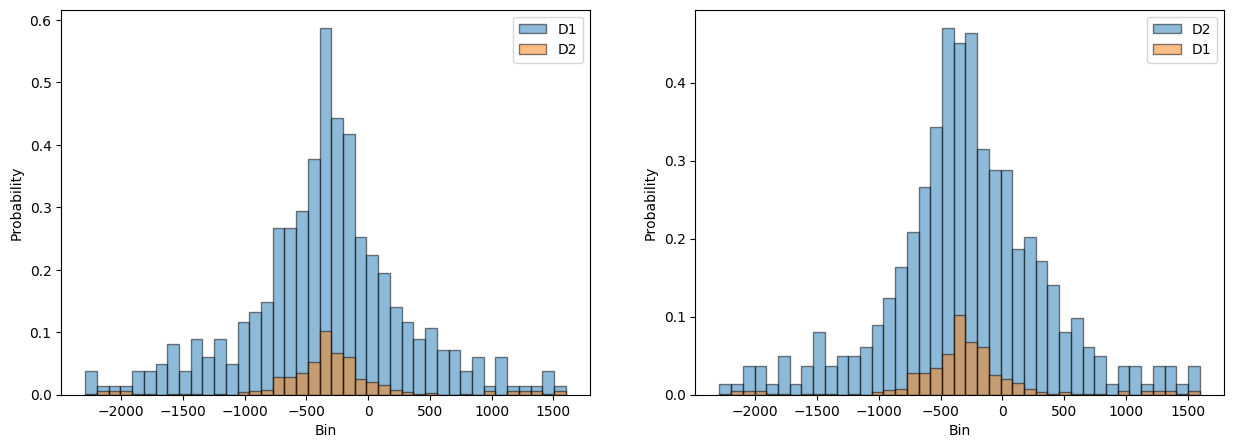

Testing:  01_1
DP Predicate Test Result:  True


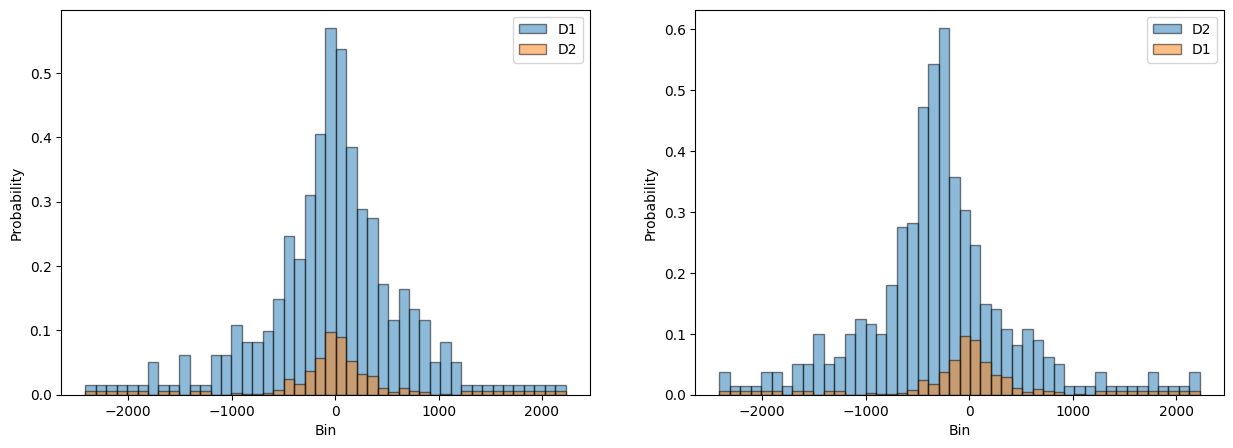

Test case:  [500.0, -777.7777777777778, 200.0]
Testing:  012_0
DP Predicate Test Result:  True


Testing:  12_1
DP Predicate Test Result:  True


Testing:  2_2
DP Predicate Test Result:  True


Testing:  12_2
DP Predicate Test Result:  True


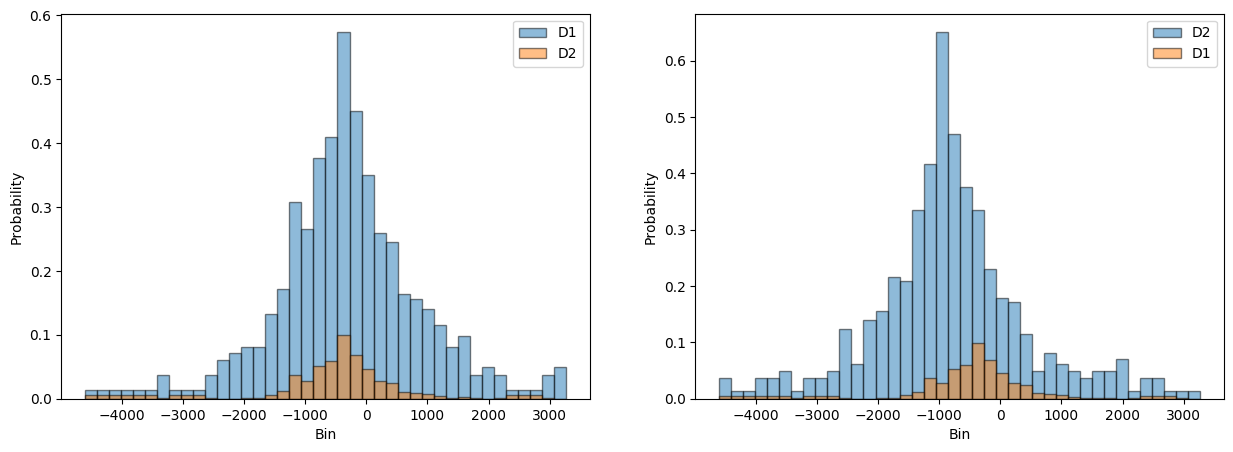

Testing:  1_1
DP Predicate Test Result:  True


Testing:  012_1
DP Predicate Test Result:  True


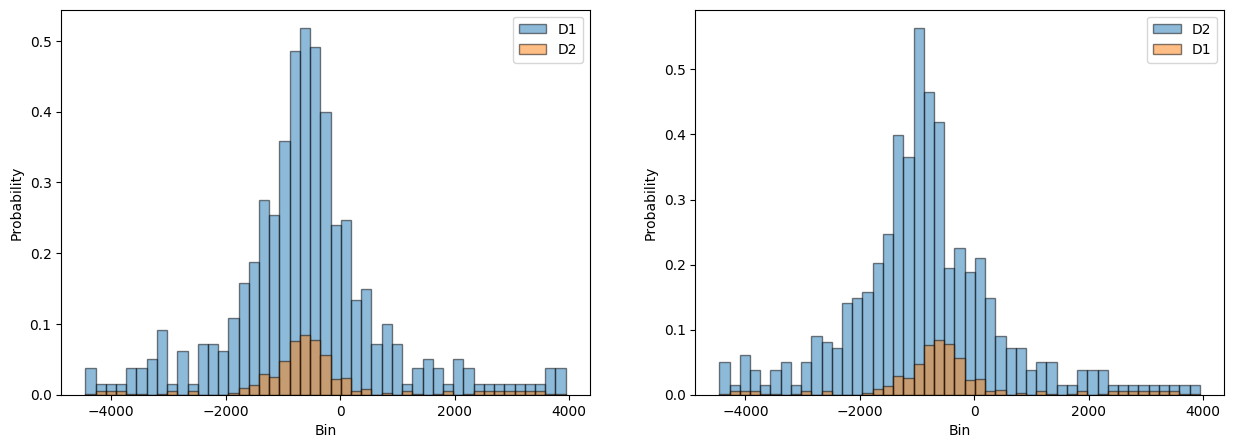

Testing:  02_0
DP Predicate Test Result:  True


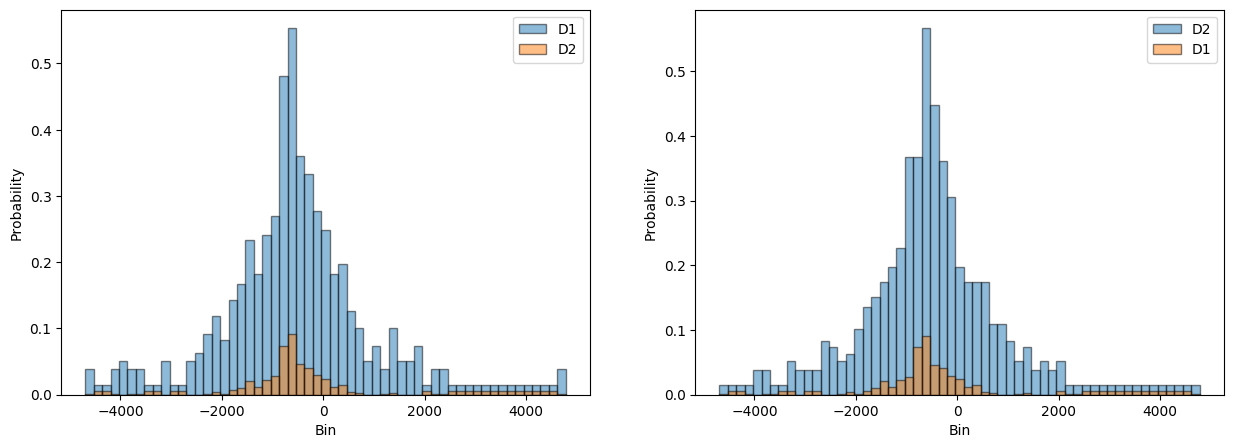

Testing:  02_2
DP Predicate Test Result:  True


Testing:  0_0


/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


DP Predicate Test Result:  True


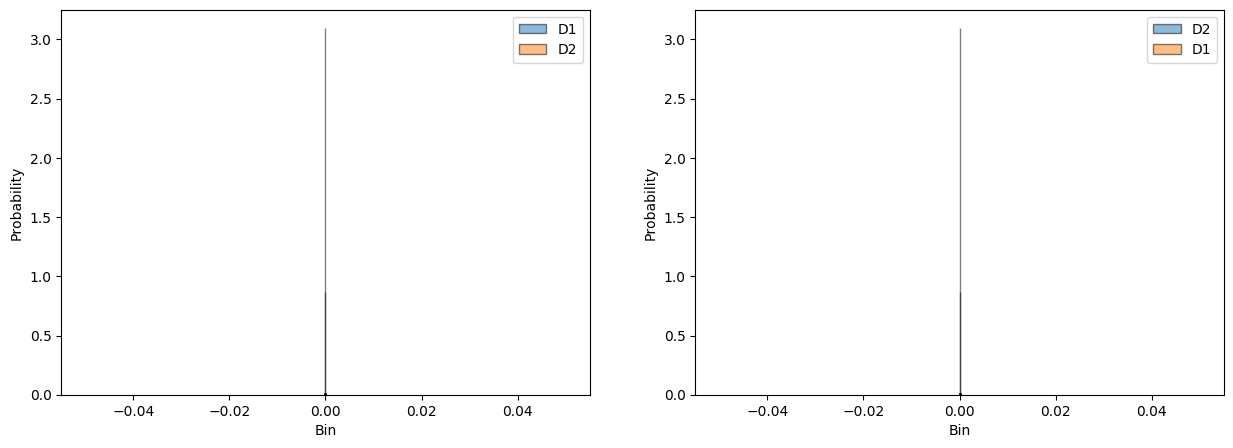

Testing:  012_2
DP Predicate Test Result:  True


Testing:  01_0
DP Predicate Test Result:  True


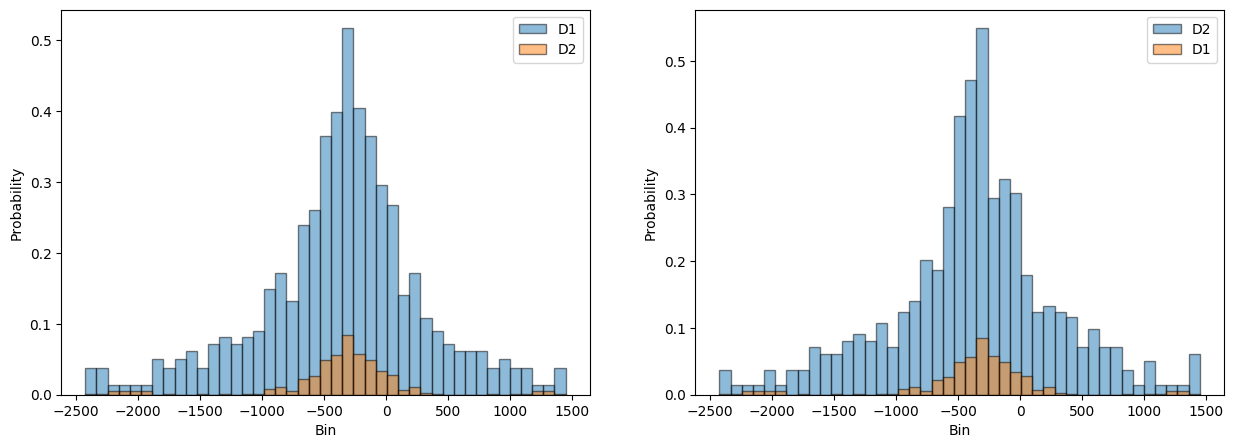

Testing:  01_1
DP Predicate Test Result:  True


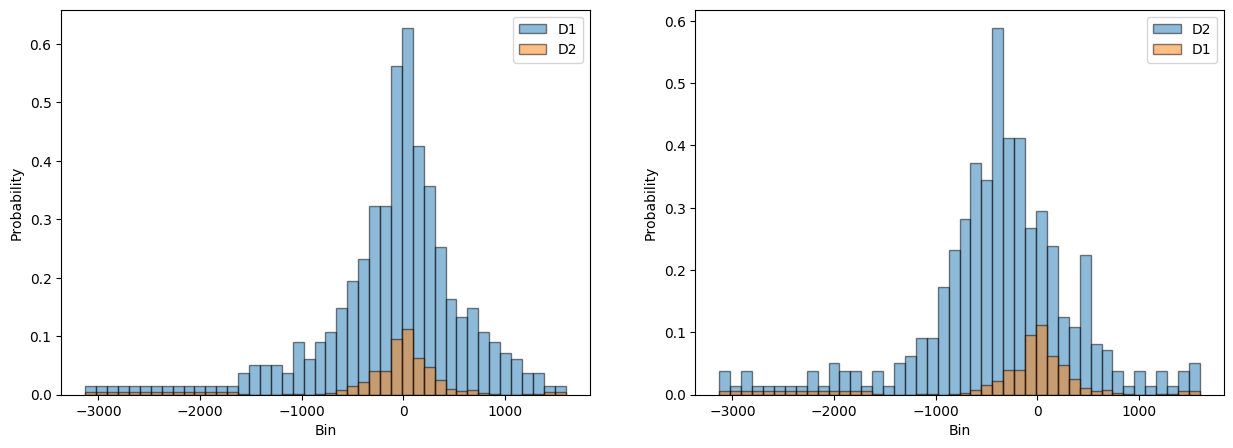

Test case:  [-750.0, -111.1111111111112, 600.0]
Testing:  012_0
DP Predicate Test Result:  True


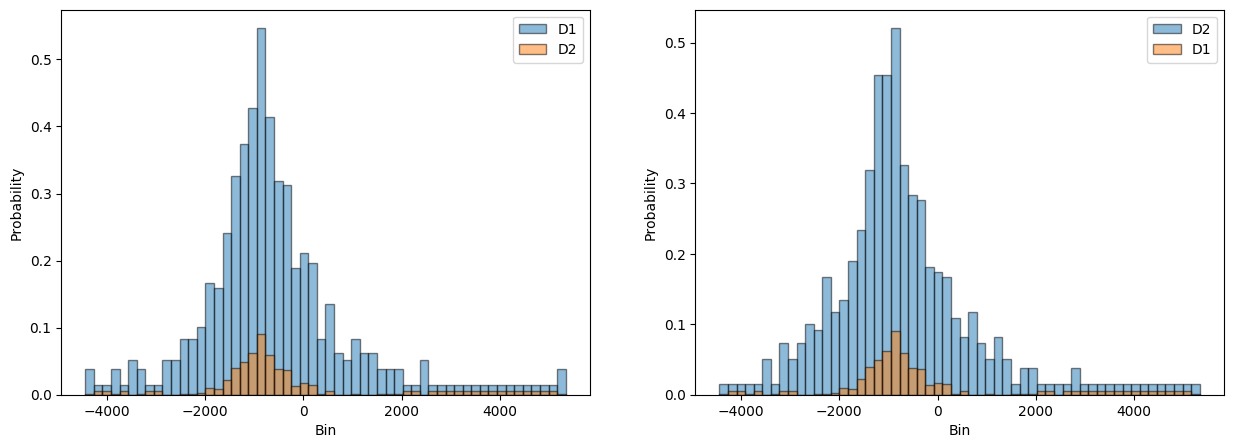

Testing:  12_1
DP Predicate Test Result:  True


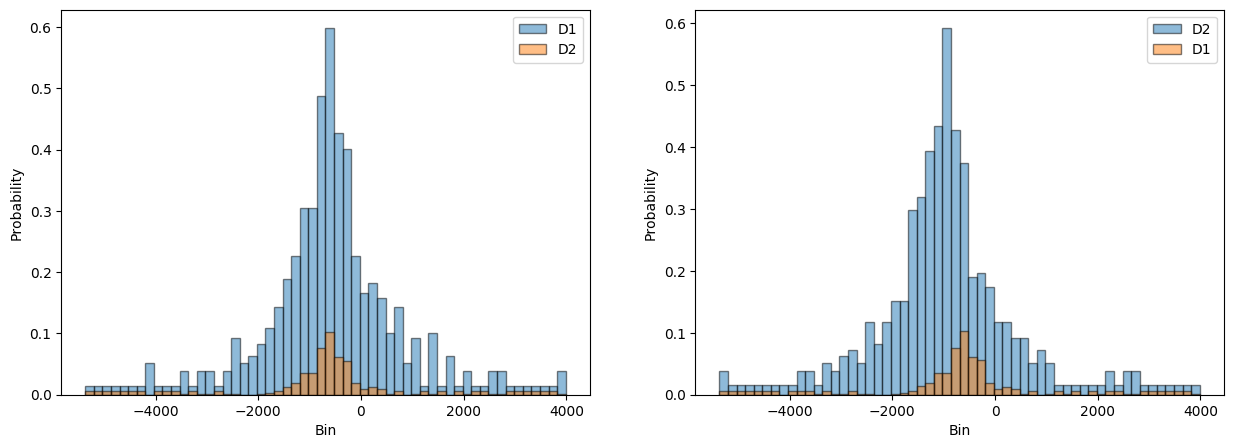

Testing:  2_2
DP Predicate Test Result:  True


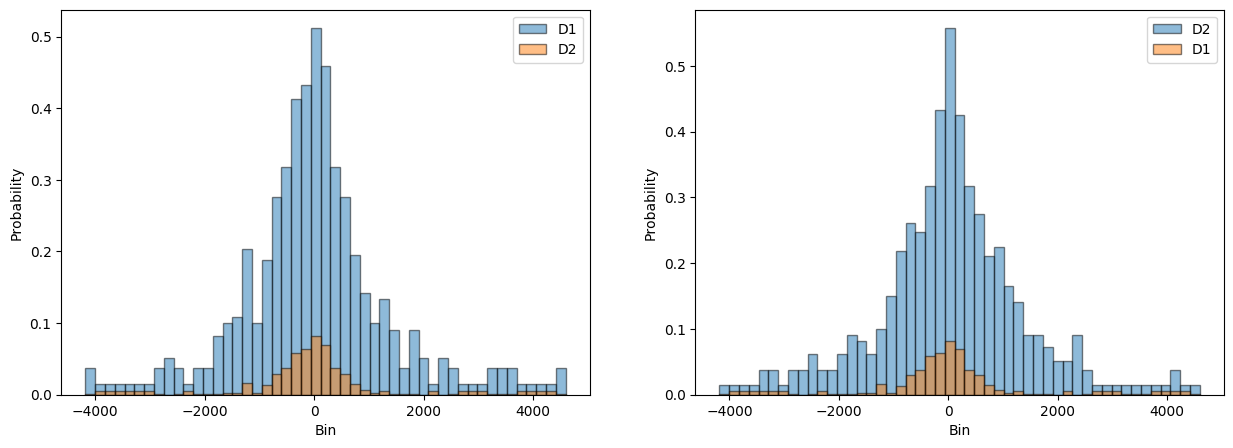

Testing:  12_2
DP Predicate Test Result:  True


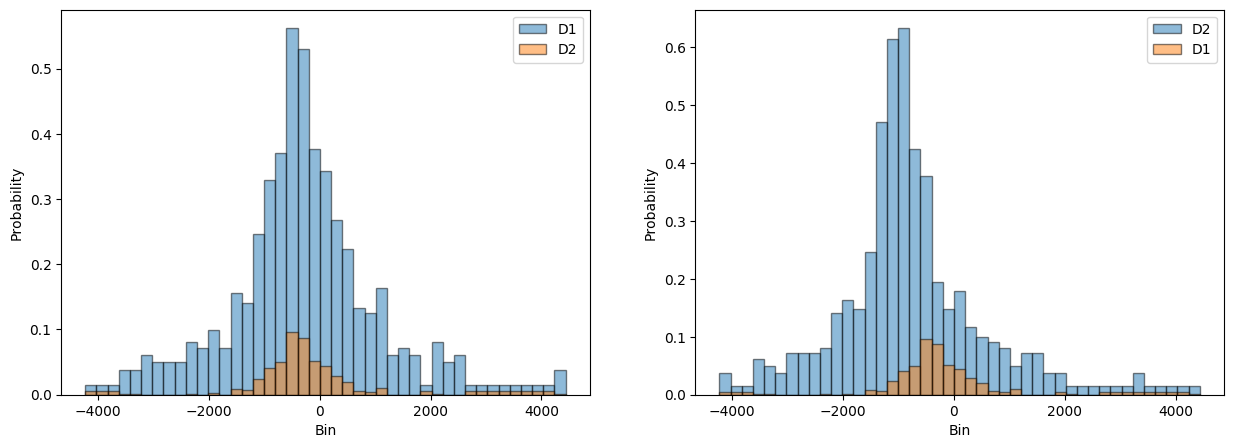

Testing:  1_1
DP Predicate Test Result:  True


Testing:  012_1
DP Predicate Test Result:  True


Testing:  02_0
DP Predicate Test Result:  True


Testing:  02_2
DP Predicate Test Result:  True


Testing:  0_0


/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


DP Predicate Test Result:  True


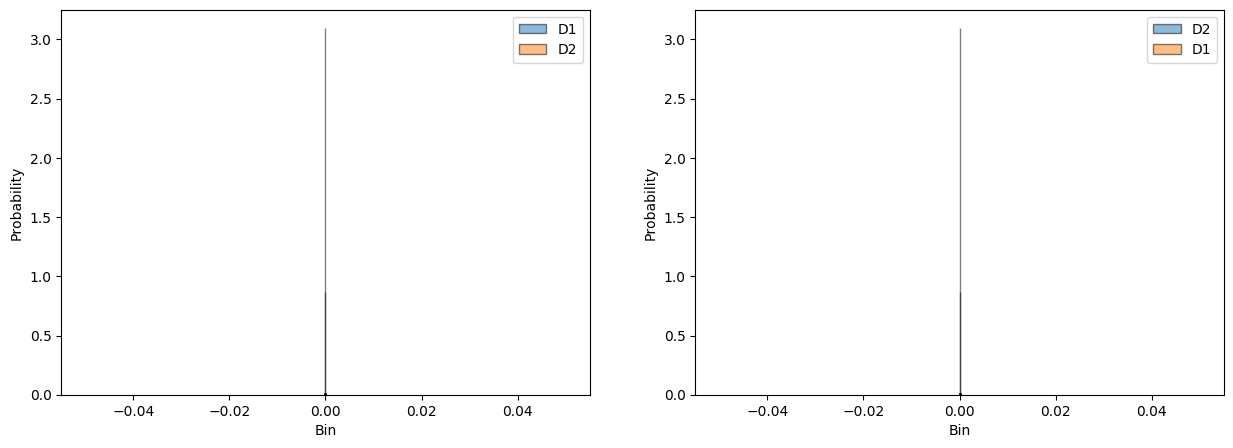

Testing:  012_2
DP Predicate Test Result:  True


Testing:  01_0
DP Predicate Test Result:  True


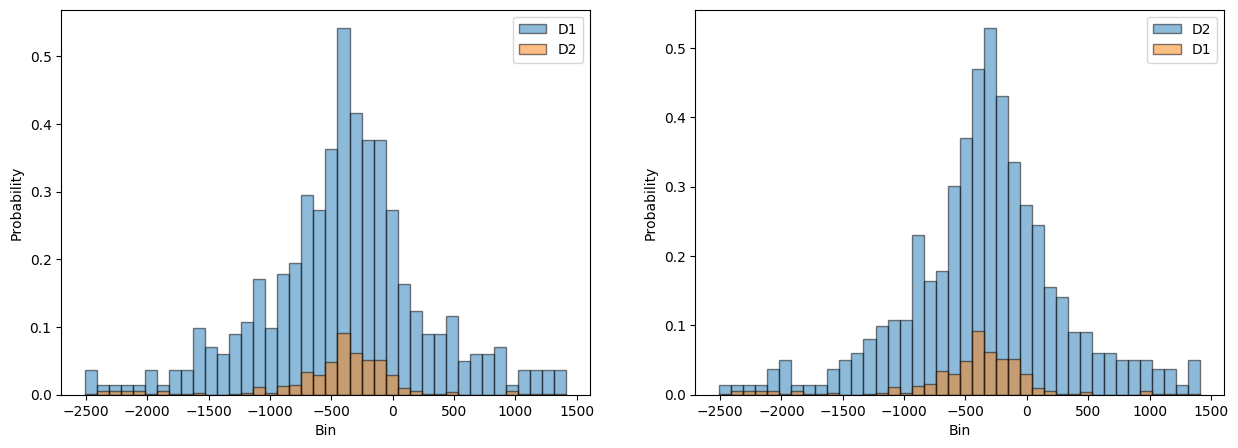

Testing:  01_1
DP Predicate Test Result:  True


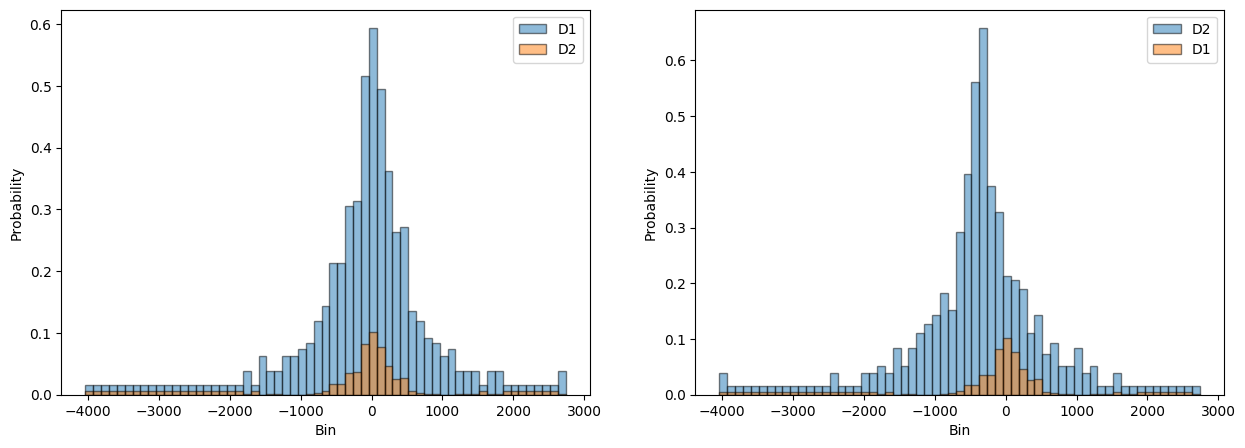

Test case:  [250.0, 555.5555555555554, -920.0]
Testing:  012_0
DP Predicate Test Result:  True


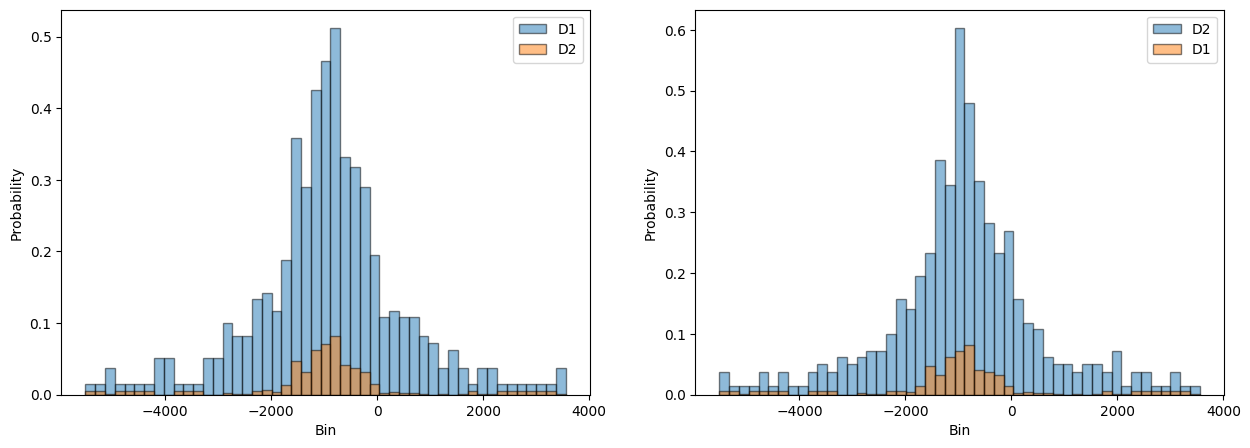

Testing:  12_1
DP Predicate Test Result:  True


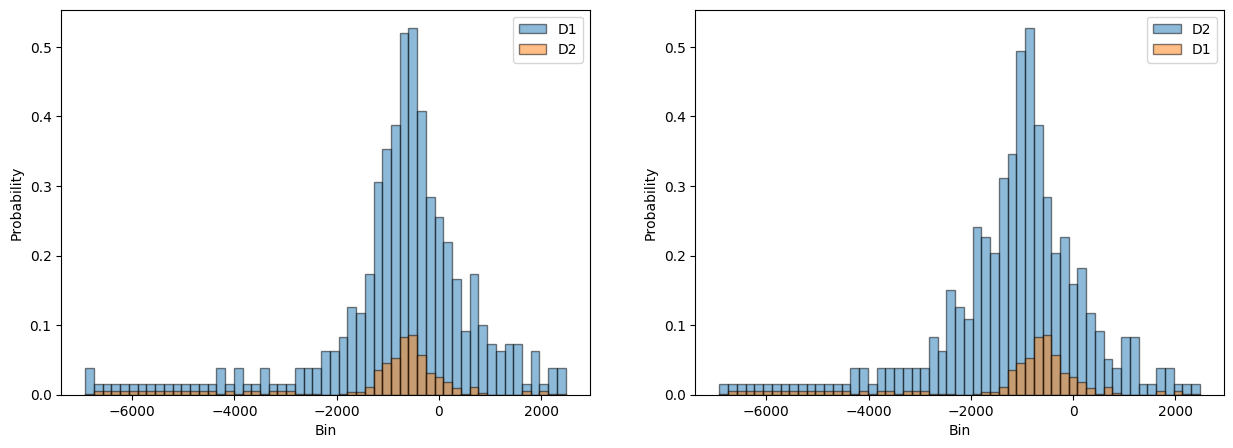

Testing:  2_2
DP Predicate Test Result:  True


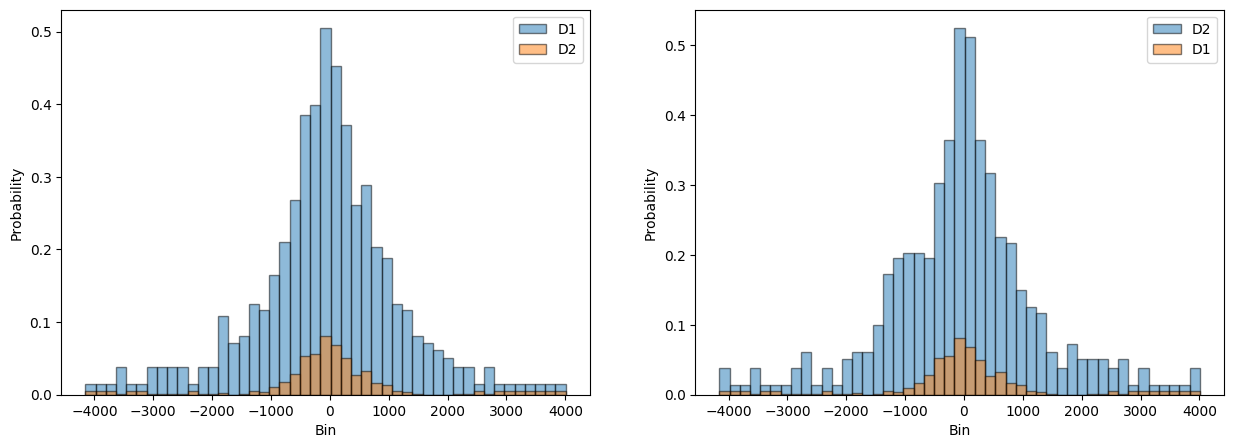

Testing:  12_2
DP Predicate Test Result:  True


Testing:  1_1
DP Predicate Test Result:  True


Testing:  012_1
DP Predicate Test Result:  True


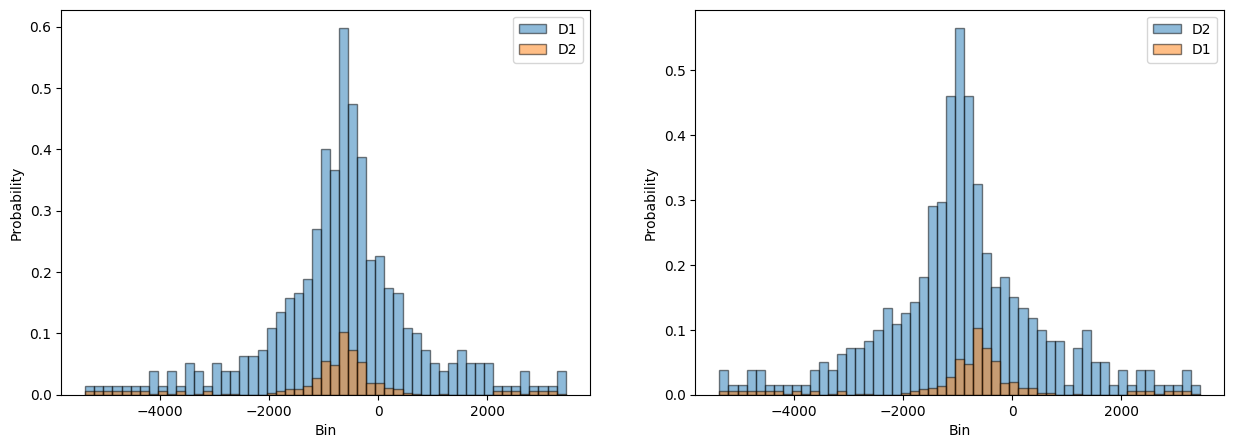

Testing:  02_0
DP Predicate Test Result:  True


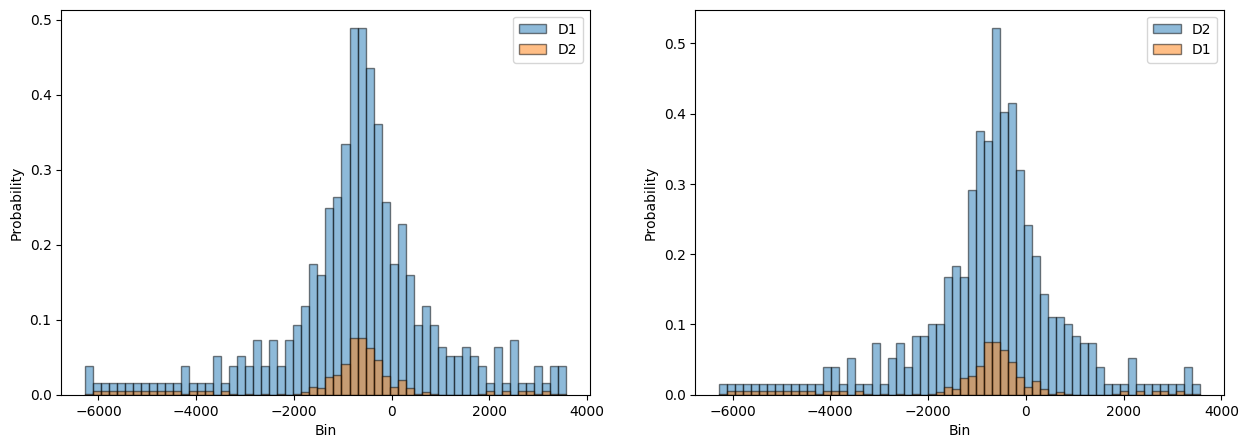

Testing:  02_2
DP Predicate Test Result:  True


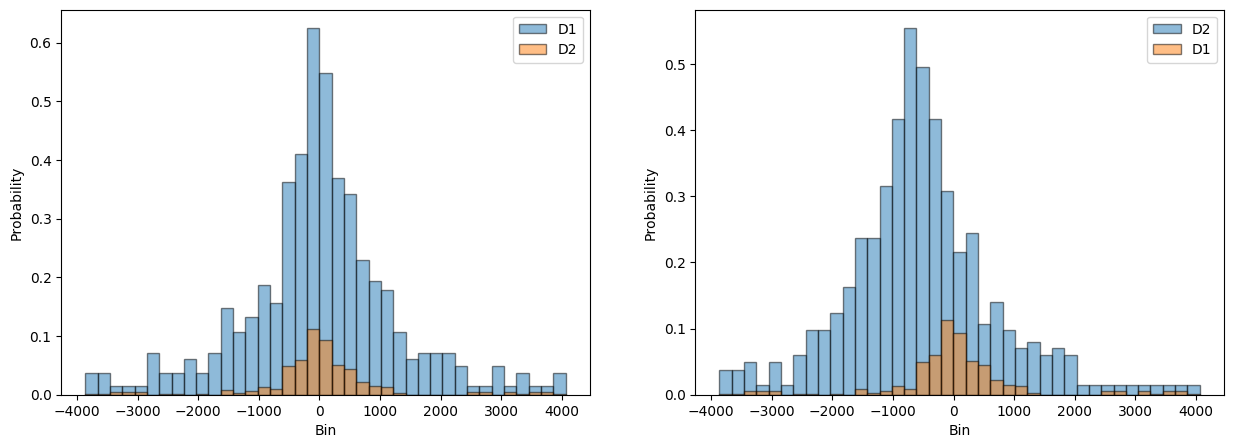

Testing:  0_0


/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/c/Users/ankitsri/code/miniconda3/envs/oss_dp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


DP Predicate Test Result:  True


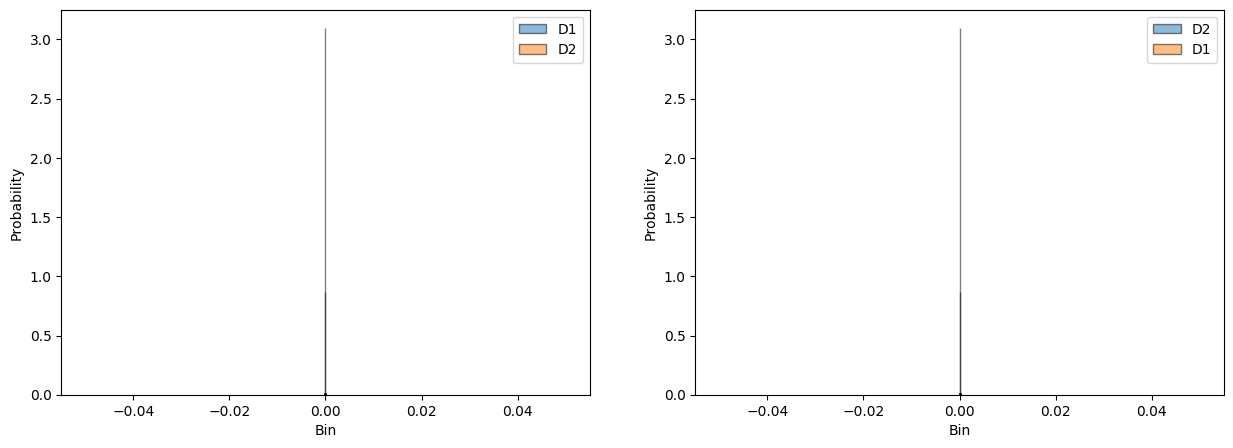

Testing:  012_2
DP Predicate Test Result:  True


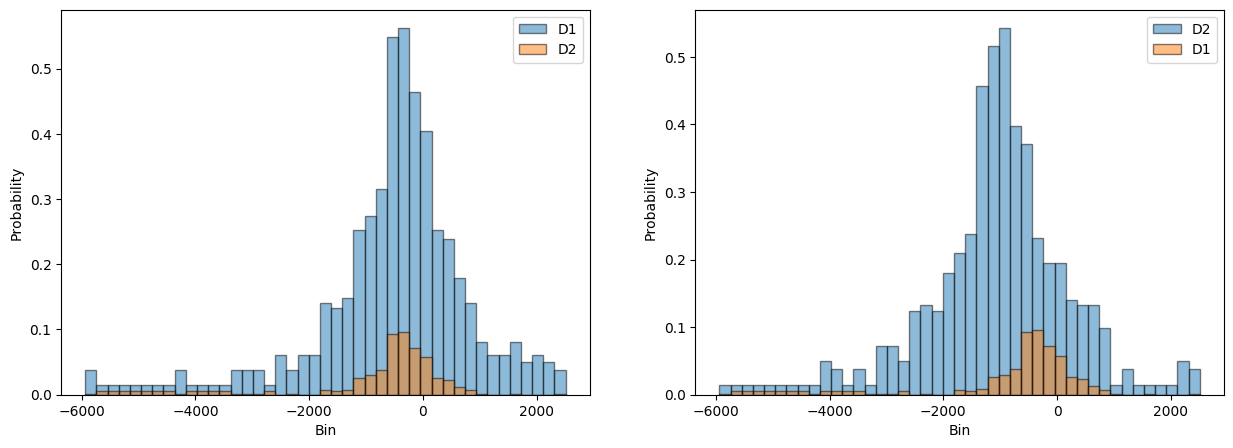

Testing:  01_0
DP Predicate Test Result:  True


Testing:  01_1
DP Predicate Test Result:  True


Halton sequence based Powerset Test Result
[0.0,-333.33333333333337,-600.0] - 012_0 - True
[0.0,-333.33333333333337,-600.0] - 12_1 - True
[0.0,-333.33333333333337,-600.0] - 2_2 - True
[0.0,-333.33333333333337,-600.0] - 12_2 - True
[0.0,-333.33333333333337,-600.0] - 1_1 - True
[0.0,-333.33333333333337,-600.0] - 012_1 - True
[0.0,-333.33333333333337,-600.0] - 02_0 - True
[0.0,-333.33333333333337,-600.0] - 02_2 - True
[0.0,-333.33333333333337,-600.0] - 0_0 - True
[0.0,-333.33333333333337,-600.0] - 012_2 - True
[0.0,-333.33333333333337,-600.0] - 01_0 - True
[0.0,-333.33333333333337,-600.0] - 01_1 - True
[-500.0,333.33333333333326,-200.0] - 012_0 - True
[-500.0,333.33333333333326,-200.0] - 12_1 - True
[-500.0,333.33333333333326,-200.0] - 2_2 - True
[-500.0,333.33333333333326,-200.0] - 12_2 - True
[-500.0,333.33333333333326,-200.0] - 1_1 - True
[-500.0,333.33333333333326,-200.0] - 012_1 - True
[-500.0,333.33333333333326,-200.0] - 02_0 - True
[-500.0,333.33333333333326,-200.0] - 02_2 - True
[

In [27]:
start_time = time.time()
query_str = "SELECT SUM(Usage) AS TotalUsage FROM "
res_list = dv.dp_powerset_test(query_str, repeat_count=500, plot=True)
print("DP Powerset Test: ", res_list)
print("--- %s seconds ---" % (time.time() - start_time))